# UniNa - Data Mining 20/21 - MiniContest n1
## Machine Learning for Alzheimer's Disease Detection
https://www.kaggle.com/c/unina-data-mining-2021-minicontest-n1/overview

## 1. Introduction
This notebook shows the solution proposed for the first Mini-Contest of the Data Mining course of University of Naples Federico II. 

The contest aims at exploiting Machine Learning for Alzheimer's disease detection. The task is to determine whether a patient has or not the disease, by means of a machine learning model trained on some medical high-level information.

More to the point, it is a **multiclass classification** problem, since the model can predict one of the following classes:
- *Assenza di patologia*, meaning that the patient is not affected by the disease;
- *Disturbo cognitivo lieve*, meaning that the patient is affected by a cognitive disorder that will not strongly affect his/her life;
- *Disturbo depressivo*, indicating that the cognitive disorder is caused by depression;
- *Malattia di Alzheimer*, indicating that the patient has Alzheimer's disease;

The prediction model has to be able to correctly predict the disease for each patient in the test set. The performance measure to maximize is the **accuracy** of the model.

### 1.1. Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
# from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Utilities
import numpy as np
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
warnings.filterwarnings('ignore')

### 1.2. Read the dataset

In [4]:
df_train_rough = pd.read_excel('dataset/TrainingSet.xlsx')
df_train_rough.head()

,ID,CAP,Scolarita,Eta,Sesso,MMSE_PG,MMSE_PC,MMSE_PE,MMSE_ESITO,CLOCKTEST_PG,...,FAB_ESITO,FLUENZAVERBFON_PG,FLUENZAVERBFON_PC,FLUENZAVERBFON_PE,FLUENZAVERBFON_ESITO,TESTMATRICIATTENTIVE_PG,TESTMATRICIATTENTIVE_PC,TESTMATRICIATTENTIVE_PE,TESTMATRICIATTENTIVE_ESITO,Patologia
0,Row0,84018,13.0,65.0,F,29.0,2849.0,238.0,NORMA,5.0,...,NaN,24.0,209.0,1.0,AI LIMITI INFERIORI DELLA NORMA,47.0,4575.0,3.0,NORMA,Malattia di Alzheimer
1,Row1,80059,8.0,70.0,M,27.0,282.0,238.0,NORMA,6.0,...,NaN,31.0,349.0,4.0,NORMA,NaN,NaN,NaN,NaN,Assenza di patologia
2,Row2,80059,12.0,70.0,F,27.0,2686.0,238.0,NORMA,NaN,...,NaN,24.0,279.0,3.0,NORMA,45.0,47.0,3.0,NORMA,Malattia di Alzheimer
3,Row3,80071,8.0,66.0,M,17.0,1753.0,238.0,DEFICIT,2.0,...,DEFICIT,4.0,72.0,0.0,DEFICIT,7.0,525.0,0.0,DEFICIT,Malattia di Alzheimer
4,Row4,80059,7.0,82.0,M,25.0,25.0,238.0,NORMA,1.0,...,DEFICIT,11.0,214.0,2.0,NORMA,37.0,4175.0,2.0,NORMA,Malattia di Alzheimer


In [5]:
print('The training set contains {:d} columns and {:d} rows.'.format(df_train_rough.shape[1], df_train_rough.shape[0]))

The training set contains 41 columns and 347 rows.


In [6]:
df_test_rough = pd.read_excel('dataset/TestSet.xlsx')
df_test_rough.head()

,ID,CAP,Scolarita,Eta,Sesso,MMSE_PG,MMSE_PC,MMSE_PE,MMSE_ESITO,CLOCKTEST_PG,...,FAB_PE,FAB_ESITO,FLUENZAVERBFON_PG,FLUENZAVERBFON_PC,FLUENZAVERBFON_PE,FLUENZAVERBFON_ESITO,TESTMATRICIATTENTIVE_PG,TESTMATRICIATTENTIVE_PC,TESTMATRICIATTENTIVE_PE,TESTMATRICIATTENTIVE_ESITO
0,Row6,80059,13.0,81.0,M,25.0,25.0,238.0,NORMA,7.0,...,1203.0,NORMA,14.0,135.0,0.0,DEFICIT,52.0,525.0,4.0,NORMA
1,Row8,80030,5.0,76.0,F,24.0,2603.0,238.0,NORMA,4.0,...,1203.0,NORMA,14.0,234.0,2.0,NORMA,NaN,NaN,NaN,NaN
2,Row9,84018,8.0,66.0,F,28.0,2853.0,238.0,NORMA,7.0,...,NaN,NaN,20.0,232.0,2.0,NORMA,38.0,NaN,2.0,NORMA
3,Row10,84018,10.0,62.0,F,27.0,2649.0,238.0,NORMA,7.0,...,NaN,NaN,41.0,435.0,4.0,NORMA,40.0,3925.0,2.0,NORMA
4,Row13,80054,14.0,59.0,F,25.0,2331.0,238.0,LIMITI,0.0,...,1203.0,NORMA,32.0,278.0,3.0,NORMA,38.0,34.0,1.0,AI LIMITI INFERIORI DELLA NORMA


In [7]:
print('The test set contains {:d} columns and {:d} rows.'.format(df_test_rough.shape[1], df_test_rough.shape[0]))

The test set contains 40 columns and 164 rows.


In [8]:
df_rough = df_train_rough.append(df_test_rough, ignore_index=True, sort=False)
df_rough.head()

,ID,CAP,Scolarita,Eta,Sesso,MMSE_PG,MMSE_PC,MMSE_PE,MMSE_ESITO,CLOCKTEST_PG,...,FAB_ESITO,FLUENZAVERBFON_PG,FLUENZAVERBFON_PC,FLUENZAVERBFON_PE,FLUENZAVERBFON_ESITO,TESTMATRICIATTENTIVE_PG,TESTMATRICIATTENTIVE_PC,TESTMATRICIATTENTIVE_PE,TESTMATRICIATTENTIVE_ESITO,Patologia
0,Row0,84018,13.0,65.0,F,29.0,2849.0,238.0,NORMA,5.0,...,NaN,24.0,209.0,1.0,AI LIMITI INFERIORI DELLA NORMA,47.0,4575.0,3.0,NORMA,Malattia di Alzheimer
1,Row1,80059,8.0,70.0,M,27.0,282.0,238.0,NORMA,6.0,...,NaN,31.0,349.0,4.0,NORMA,NaN,NaN,NaN,NaN,Assenza di patologia
2,Row2,80059,12.0,70.0,F,27.0,2686.0,238.0,NORMA,NaN,...,NaN,24.0,279.0,3.0,NORMA,45.0,47.0,3.0,NORMA,Malattia di Alzheimer
3,Row3,80071,8.0,66.0,M,17.0,1753.0,238.0,DEFICIT,2.0,...,DEFICIT,4.0,72.0,0.0,DEFICIT,7.0,525.0,0.0,DEFICIT,Malattia di Alzheimer
4,Row4,80059,7.0,82.0,M,25.0,25.0,238.0,NORMA,1.0,...,DEFICIT,11.0,214.0,2.0,NORMA,37.0,4175.0,2.0,NORMA,Malattia di Alzheimer


In [9]:
print('The whole dataset contains {:d} columns and {:d} rows.'.format(df_rough.shape[1], df_rough.shape[0]))

The whole dataset contains 41 columns and 511 rows.


### 1.3. Data understanding
The first thing we can notice is that the dataset has a well-defined pattern. Except some general feature such as **scolarity**, **age** and **gender**, it is composed of different subsets of similar attributes. Each subset refers to a particular test used in neuropsychiatry to evaluate cognitive abilities of the patients. All the subsets share the same attributes:
- **PG**: literally 'Punteggio Grezzo', it is the rough score obtained by a patient in the test.
- **PC**: literally 'Punteggio Corretto', it is the score of the patient adjusted taking into account his age and scolarity.
- **PE**: literally 'Punteggio Equivalente', it is a numeric value from 0 to 4 that indicate where the score of the patient is placed compared to other patients. More to the point, PE would be:
    - 0 if the score is under the 5° percentile (with a probability of 95%);
    - 1 if the score is between the 5° percentile and the 20° percentile;
    - 2 if the score is between the 20° percentile and the 35° percentile;
    - 3 if the score is between the 35° percentile and the 50° percentile;
    - 4 if the score is over the 50° percentile;
- **ESITO**: it is the final result of the test.

## 2. Preprocessing
Before proceeding with modelling, we need to do some preprocessing steps.

### 2.1. Data cleaning
First of all, we need to verify the data format. In other words, we need to check if data of each feature lie in the correct range of values.

In [10]:
df_clean = df_rough.copy()

#### Scolarity

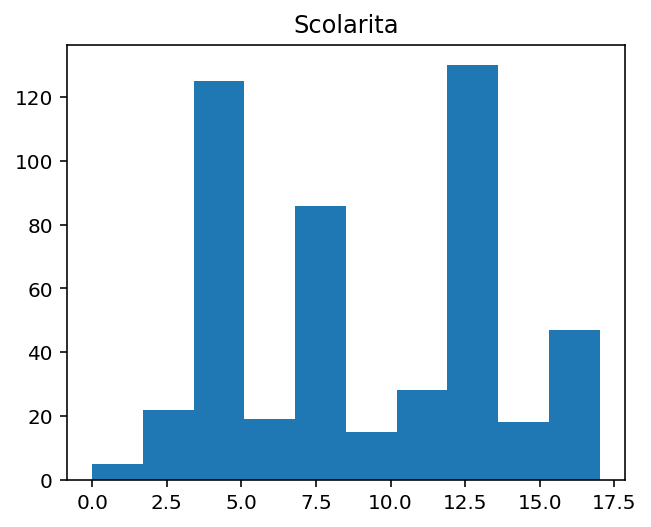

In [11]:
df_rough.hist(column=['Scolarita'], figsize=(5,4), grid=False)
plt.show()

#### Age

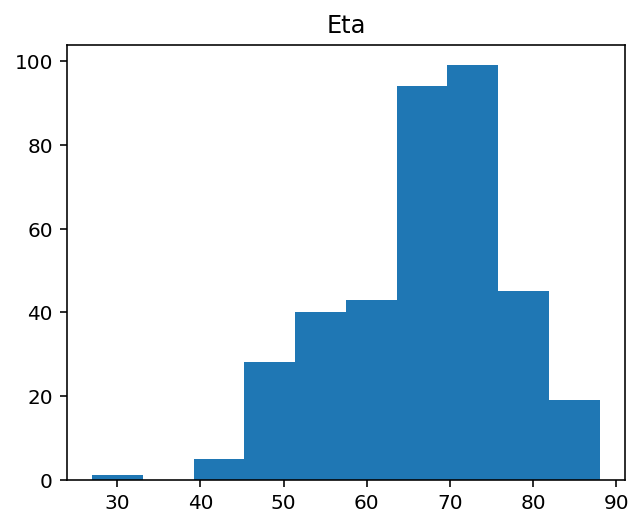

In [12]:
df_rough.hist(column=['Eta'], figsize=(5,4), grid=False)
plt.show()

#### Gender

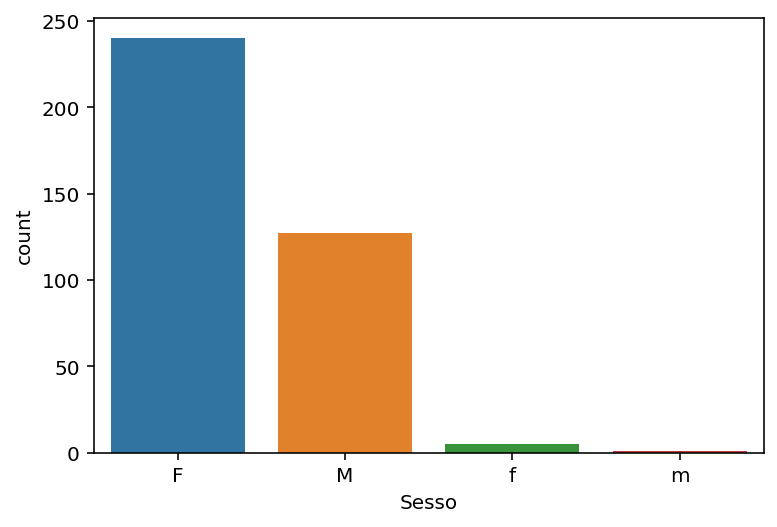

In [13]:
sns.countplot(df_rough.Sesso)
plt.show()

As we can see, there is a little inconsistency in the gender feature: sometimes *m* and *f* have been used instead of *M* and *F*.

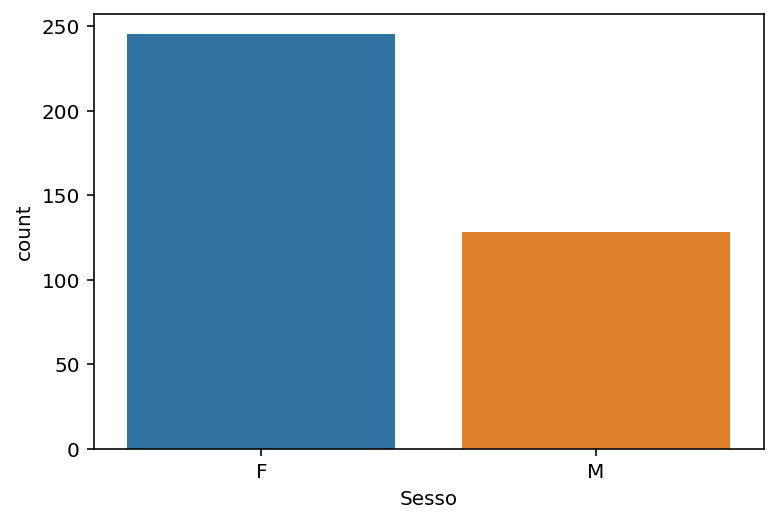

In [14]:
df_clean['Sesso'].replace(to_replace={'m':'M', 'f':'F'}, inplace=True)
sns.countplot(df_clean.Sesso)
plt.show()

#### Mini Mental State Examination (MMSE)
According to some online research, the range of MMSE_PG is [0,32], so we expect also for MMSE_PC values near to this range. 

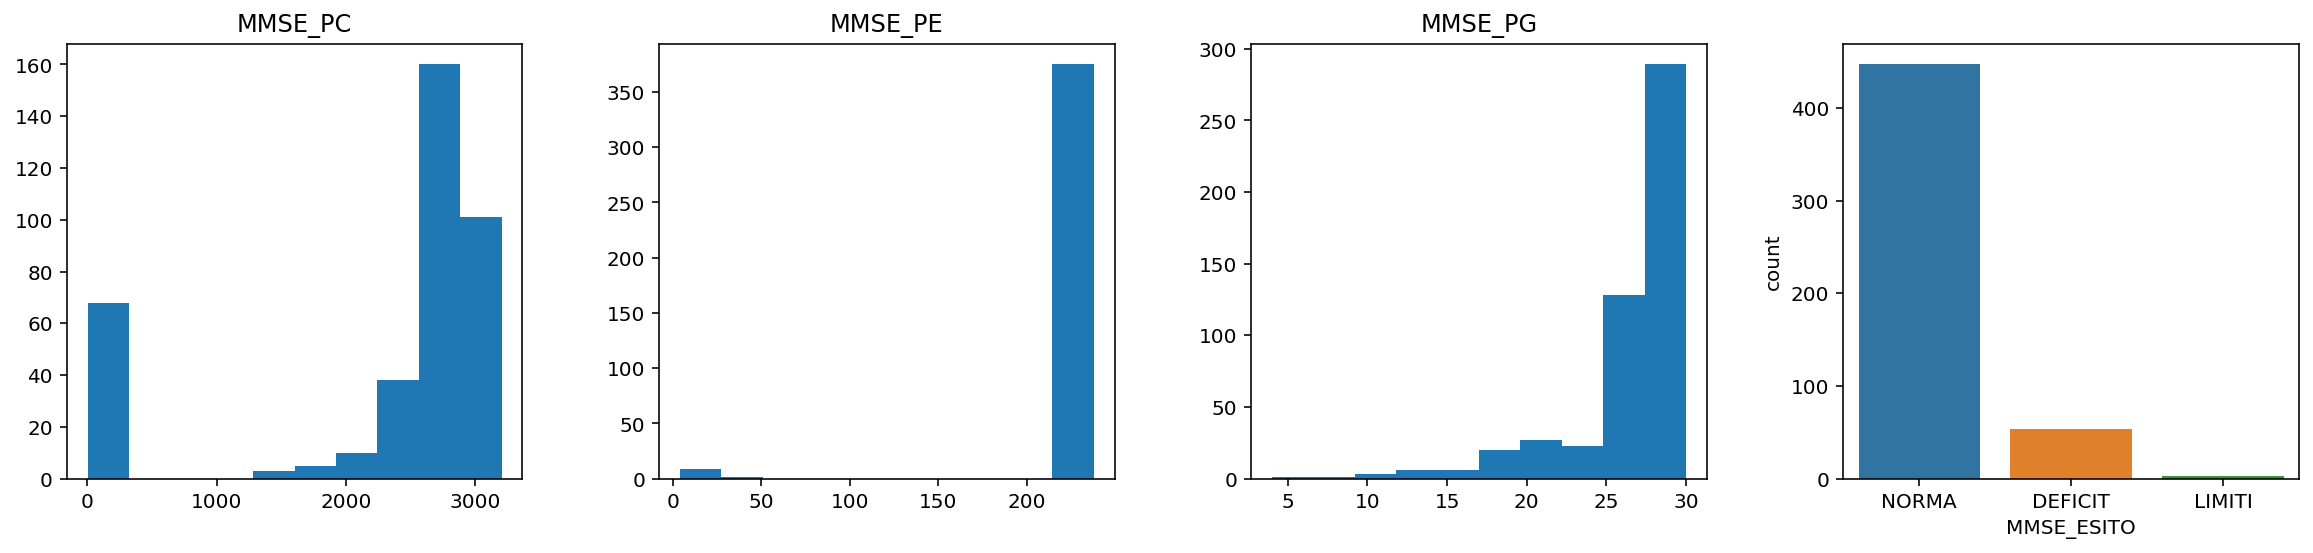

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['MMSE_PG', 'MMSE_PC', 'MMSE_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.MMSE_ESITO, ax=axs[3])
plt.show()

MMSE_PC values are far away from their correct range. Looking at the dataset we can see that lots of them are missing the comma, so they are greater by one or two orders of magnitude than their real value. We need to scale them properly.

Moreover, it seems that the MMSE_PE feature does not make any sense, since it contains the same value for almost all rows of the dataset. Fortunately, we can recover it from the correct values of MMSE_PC.

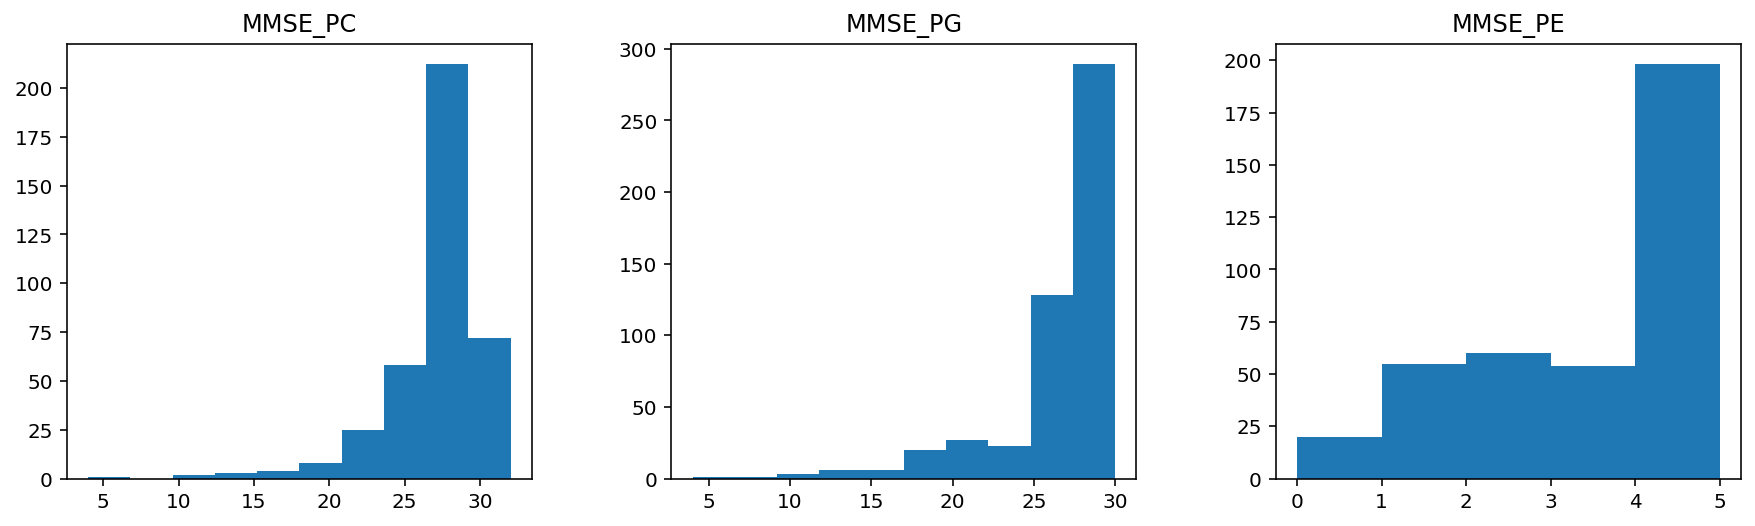

In [16]:
df_clean.loc[df_clean.MMSE_PC > 1000 , 'MMSE_PC'] = df_clean.MMSE_PC/100
df_clean.loc[df_clean.MMSE_PC > 100 , 'MMSE_PC'] = df_clean.MMSE_PC/10

MMSE_percentiles = df_clean.describe(percentiles=[.05, .20, .35, .50]).loc[['5%','20%','35%','50%'],['MMSE_PC']]

df_clean.loc[df_clean.MMSE_PC < MMSE_percentiles.loc['5%'].values[0], 'MMSE_PE'] = 0
df_clean.loc[(df_clean.MMSE_PC >= MMSE_percentiles.loc['5%'].values[0]) & (df_clean.MMSE_PC < MMSE_percentiles.loc['20%'].values[0]), 'MMSE_PE'] = 1
df_clean.loc[(df_clean.MMSE_PC >= MMSE_percentiles.loc['20%'].values[0]) & (df_clean.MMSE_PC < MMSE_percentiles.loc['35%'].values[0]), 'MMSE_PE'] = 2
df_clean.loc[(df_clean.MMSE_PC >= MMSE_percentiles.loc['35%'].values[0]) & (df_clean.MMSE_PC < MMSE_percentiles.loc['50%'].values[0]), 'MMSE_PE'] = 3
df_clean.loc[(df_clean.MMSE_PC >= MMSE_percentiles.loc['50%'].values[0]), 'MMSE_PE'] = 4
df_clean.loc[df_clean.MMSE_PE > 4, 'MMSE_PE'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['MMSE_PG', 'MMSE_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['MMSE_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

After manipulated the data, it's better to verify that we didn't make any mistake. To do so, we can plot each feature related to MMSE, grouping each of them by the result of the test. If mistakes occur, we should see some points in "wrong" positions of the plots (e.g. patients with *DEFICIT* in the higher area, patients with *NORMA* in the lowest area).

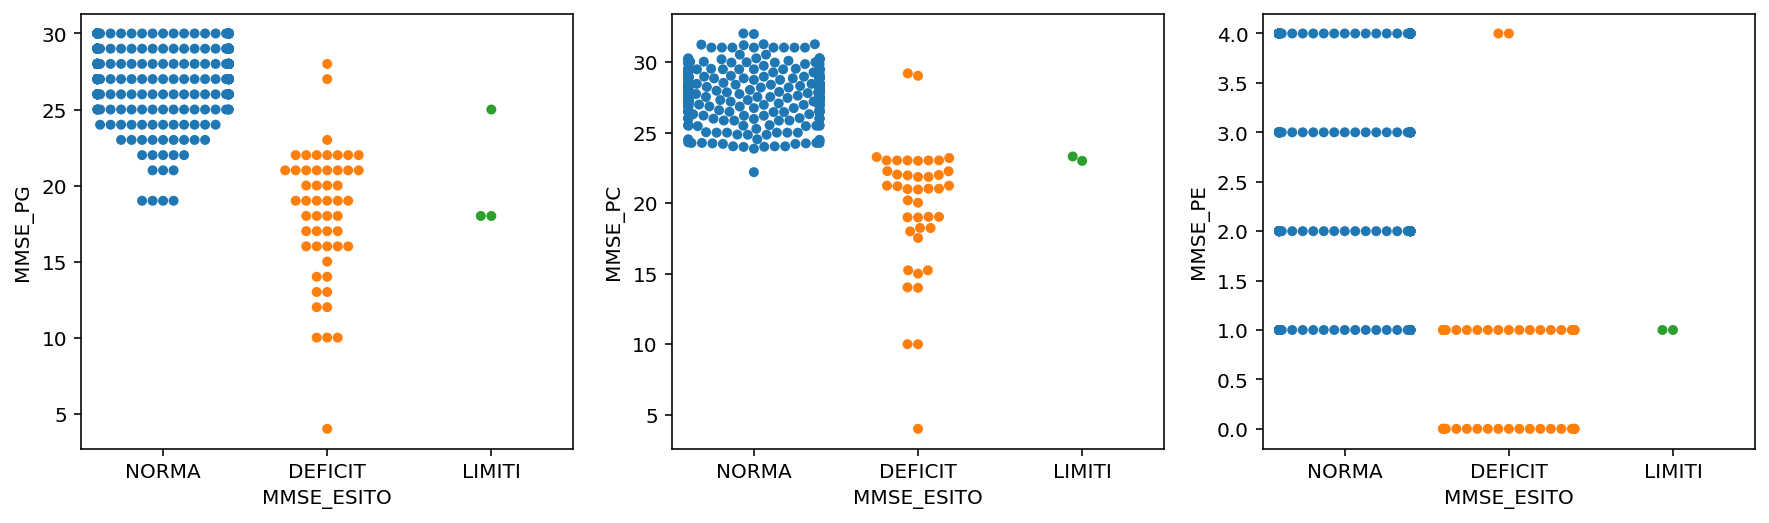

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='MMSE_ESITO', y='MMSE_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='MMSE_ESITO', y='MMSE_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='MMSE_ESITO', y='MMSE_PE', data=df_clean, ax=axs[2])
plt.show()

According to the plots no mistakes has been made. Anyway, some outliers does exists, even in the MMSE_PG that hasn't been manipulated. This is not necessarily a problem, as it can seen as noise in the features, which should be left in the dataset.

We will follow the same workflow for all the following features, related to different tests.

#### Clock test
- CLOCKTEST_PG range: [0,10]

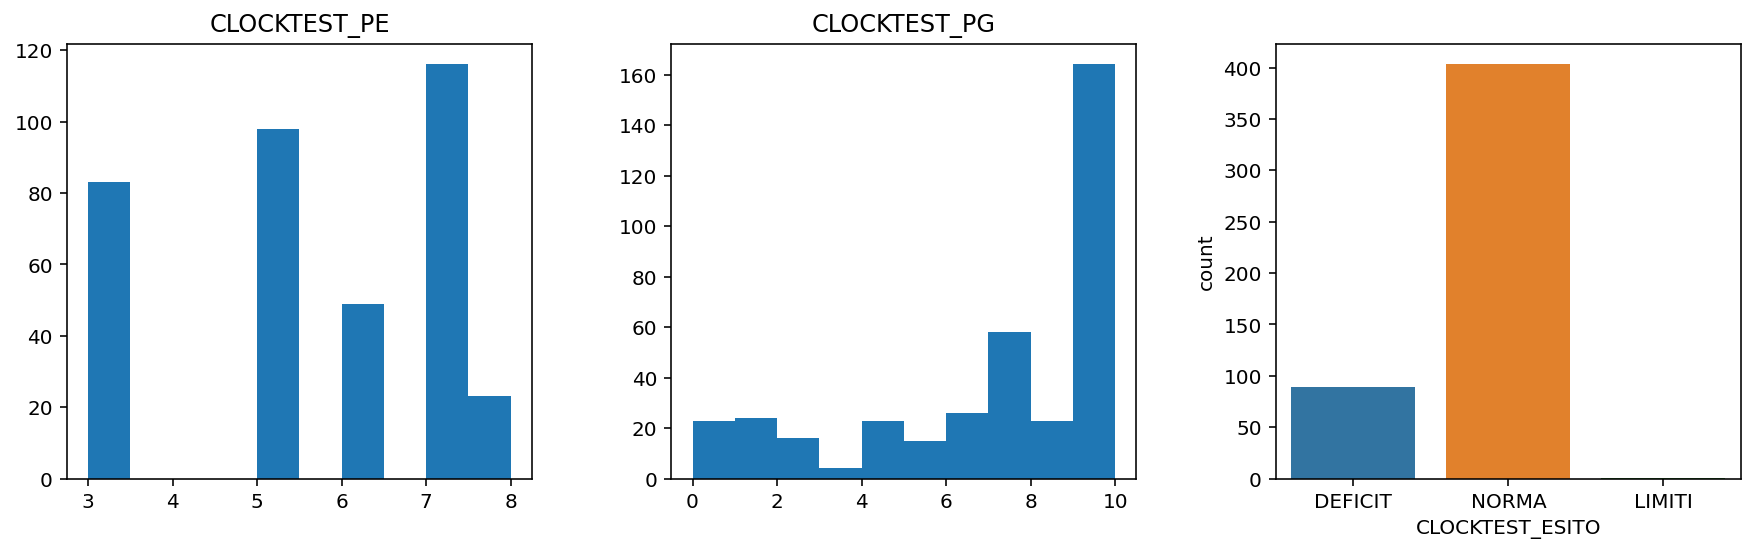

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_rough.hist(column=['CLOCKTEST_PG', 'CLOCKTEST_PE'], figsize=(10,8), ax=axs[0:2], grid=False)
sns.countplot(df_rough.CLOCKTEST_ESITO, ax=axs[2])
plt.show()

Values of CLOCKTEST_PE are incorrect, since they must vary from 0 to 4. 

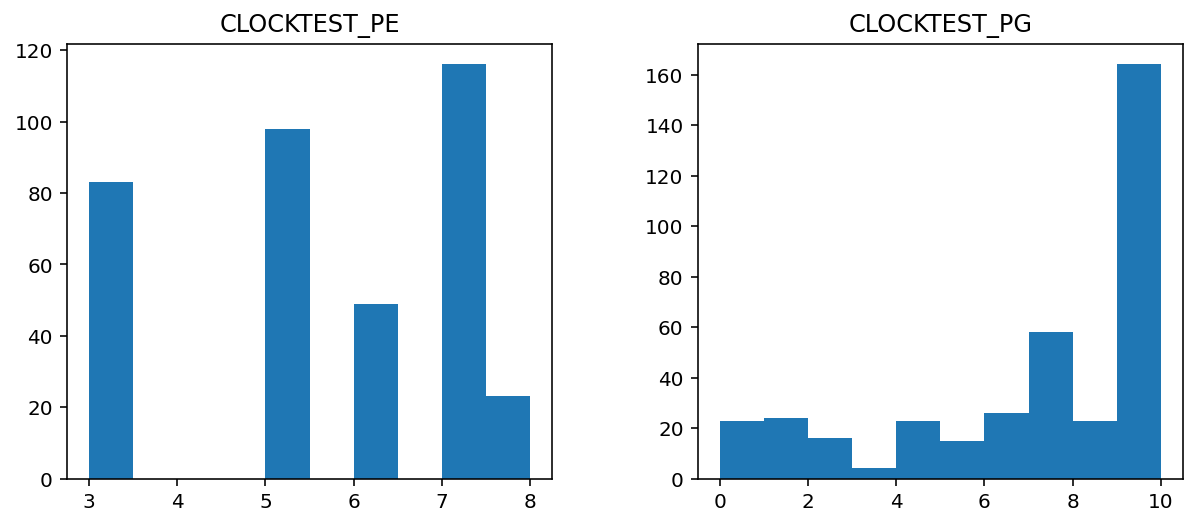

In [19]:
df_clean.hist(column=['CLOCKTEST_PG', 'CLOCKTEST_PE'], figsize=(10,4), grid=False)
plt.show()

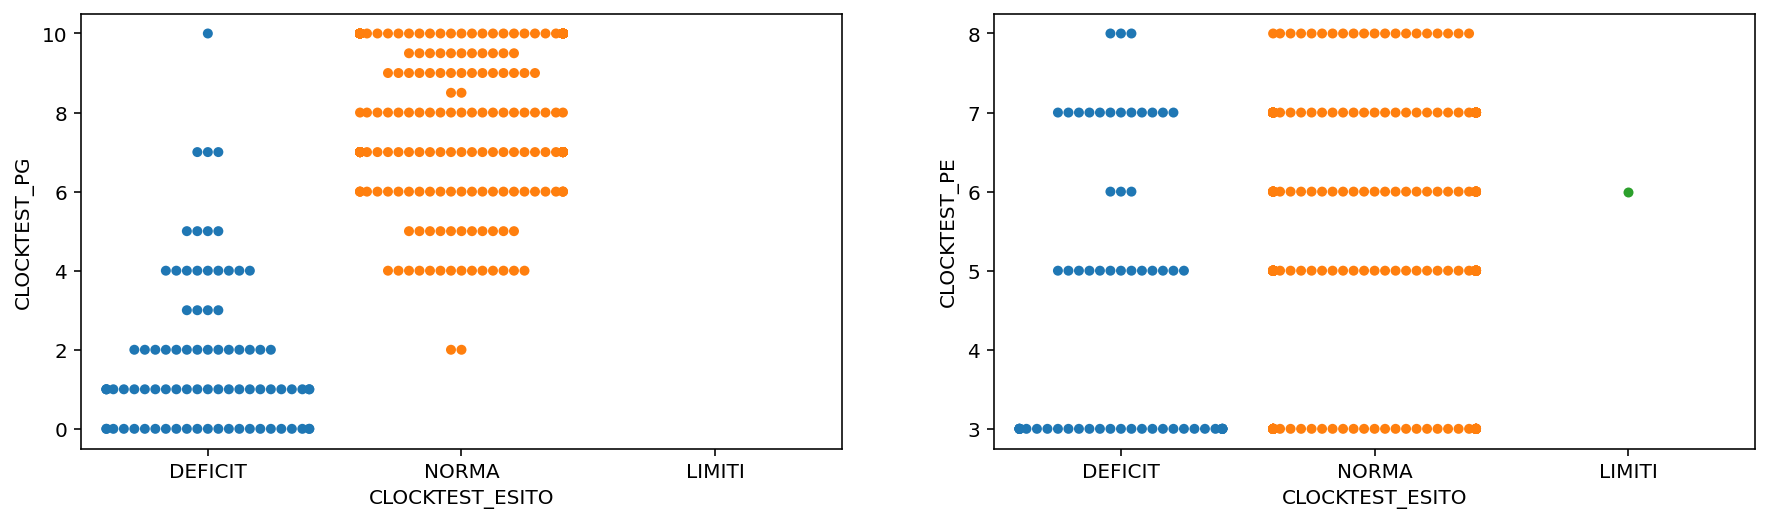

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
sns.swarmplot(x='CLOCKTEST_ESITO', y='CLOCKTEST_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='CLOCKTEST_ESITO', y='CLOCKTEST_PE', data=df_clean, ax=axs[1])
plt.show()

It could be possible that values of CLOCKTEST_PE represent instead values of CLOCKTEST_PC, which is missing in the dataset. However, plotting CLOCKTEST_PE grouped by CLOCKTEST_ESITO, we can't see any correlation between these attribute, which is not what we expect. 

Therefore, we may conclude that CLOCKTEST_PE should be discarded from the dataset.

#### Ray figure copy test
- COPIAFIGURAREY_PG range: [0,40]

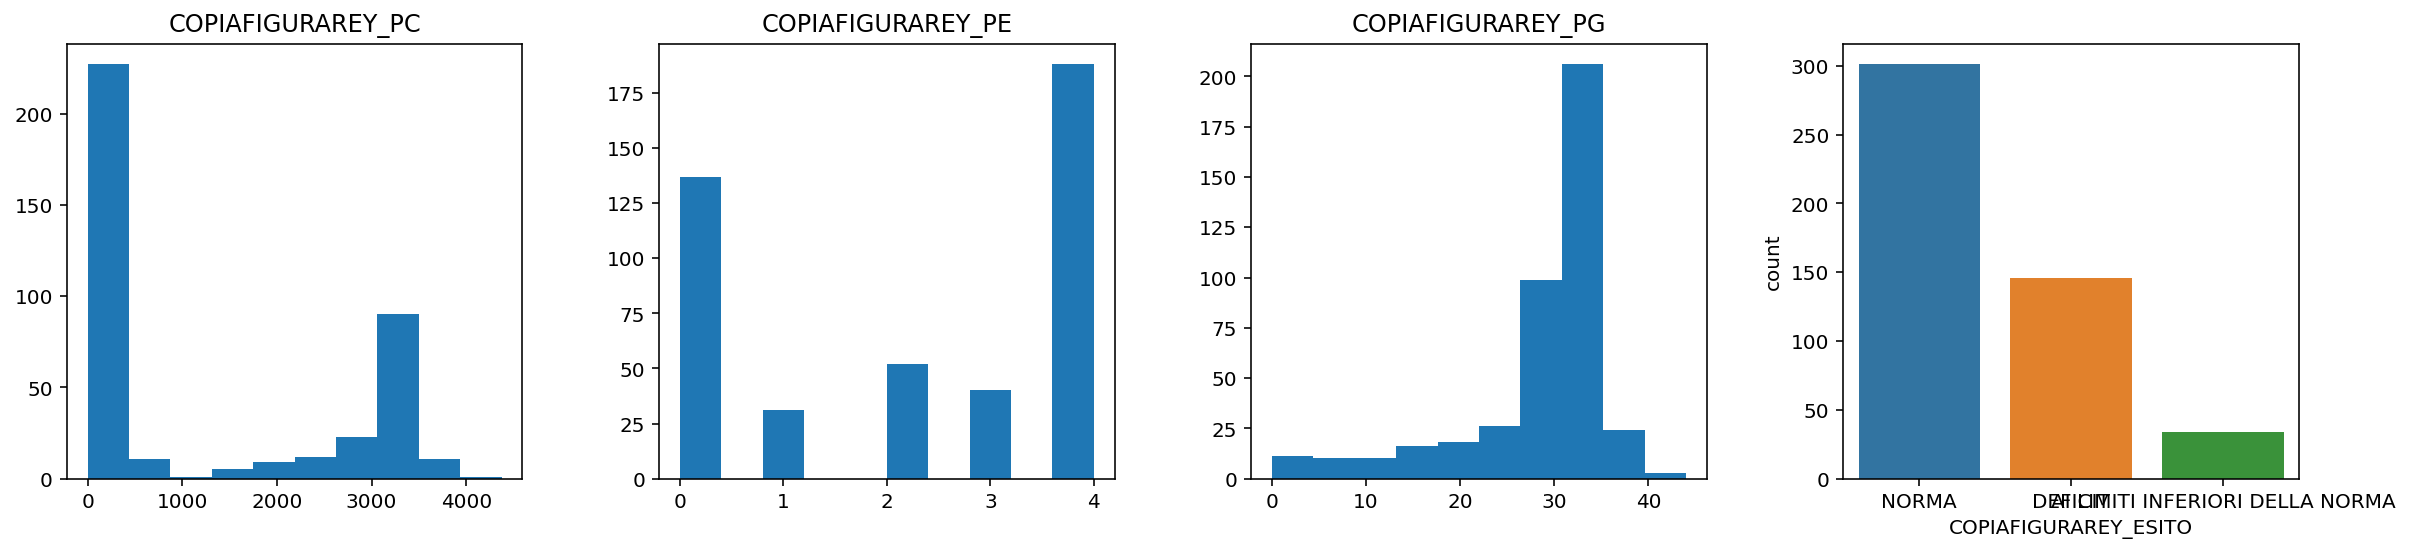

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['COPIAFIGURAREY_PG', 'COPIAFIGURAREY_PC', 'COPIAFIGURAREY_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.COPIAFIGURAREY_ESITO, ax=axs[3])
plt.show()

Looking at the dataset we can see not only that lots of COPIAFIGURAREY_PC values are missing the comma, but also that some of them represent the COPIAFIGURAREY_PC value of the same row.

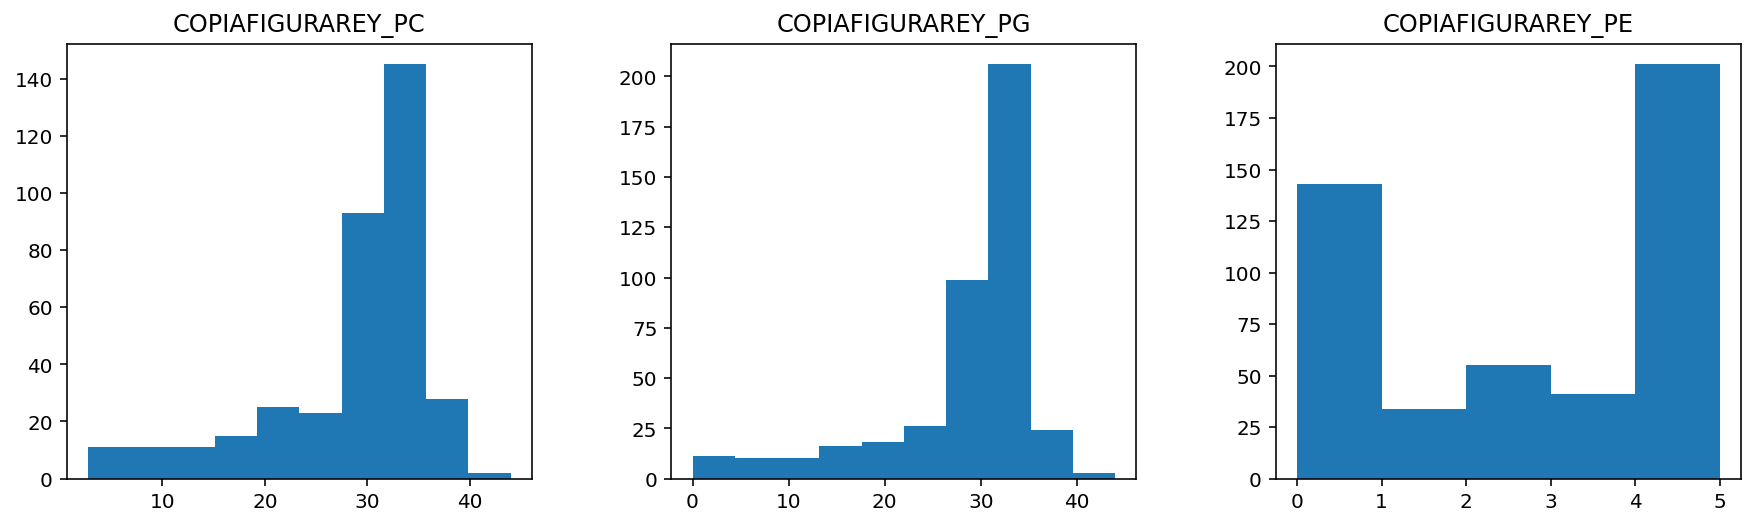

In [22]:
df_clean['COPIAFIGURAREY_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean.loc[df_clean.COPIAFIGURAREY_PC > 1000, 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/100
df_clean.loc[(df_clean.COPIAFIGURAREY_PC > 100) & (df_clean.COPIAFIGURAREY_PG >= 10), 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/10
df_clean.loc[(df_clean.COPIAFIGURAREY_PC > 100) & (df_clean.COPIAFIGURAREY_PG < 10), 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/100
df_clean.loc[(df_clean.COPIAFIGURAREY_PC > 100) & (df_clean.COPIAFIGURAREY_PG.isnull()), 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/10
df_clean.loc[(df_clean.COPIAFIGURAREY_PC > 50) & (df_clean.COPIAFIGURAREY_PG.isnull()), 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/10
df_clean.loc[(df_clean.COPIAFIGURAREY_PC > 10) & (df_clean.COPIAFIGURAREY_PG < 10), 'COPIAFIGURAREY_PC'] = df_clean.COPIAFIGURAREY_PC/10

df_clean.loc[(df_clean.COPIAFIGURAREY_PC <= 4) & (df_clean.COPIAFIGURAREY_PE.isnull()), 'COPIAFIGURAREY_PE'] = df_clean.COPIAFIGURAREY_PC
df_clean.loc[(df_clean.COPIAFIGURAREY_PC <= 4) & (df_clean.COPIAFIGURAREY_PE == df_clean.COPIAFIGURAREY_PC), 'COPIAFIGURAREY_PC'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['COPIAFIGURAREY_PG', 'COPIAFIGURAREY_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['COPIAFIGURAREY_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

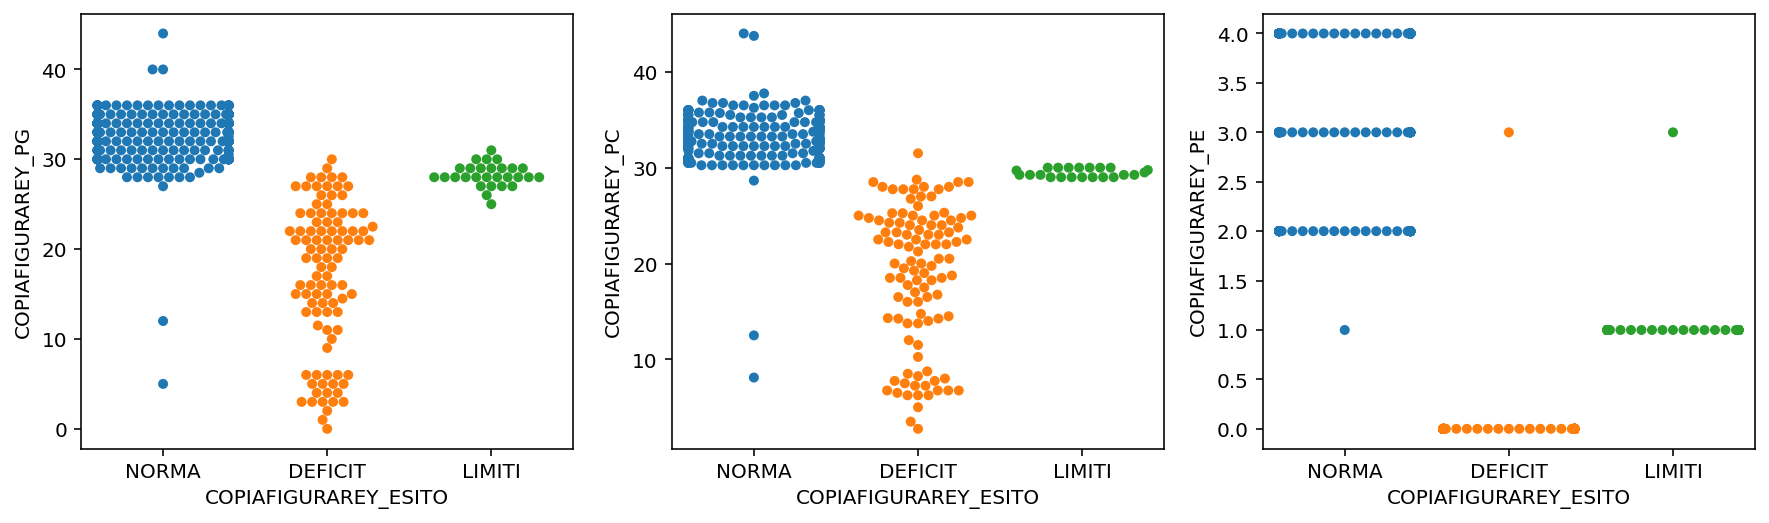

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='COPIAFIGURAREY_ESITO', y='COPIAFIGURAREY_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='COPIAFIGURAREY_ESITO', y='COPIAFIGURAREY_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='COPIAFIGURAREY_ESITO', y='COPIAFIGURAREY_PE', data=df_clean, ax=axs[2])
plt.show()

#### Ray figure memory test
- MEMORIAFIGURAREY_PG range: [0,40]

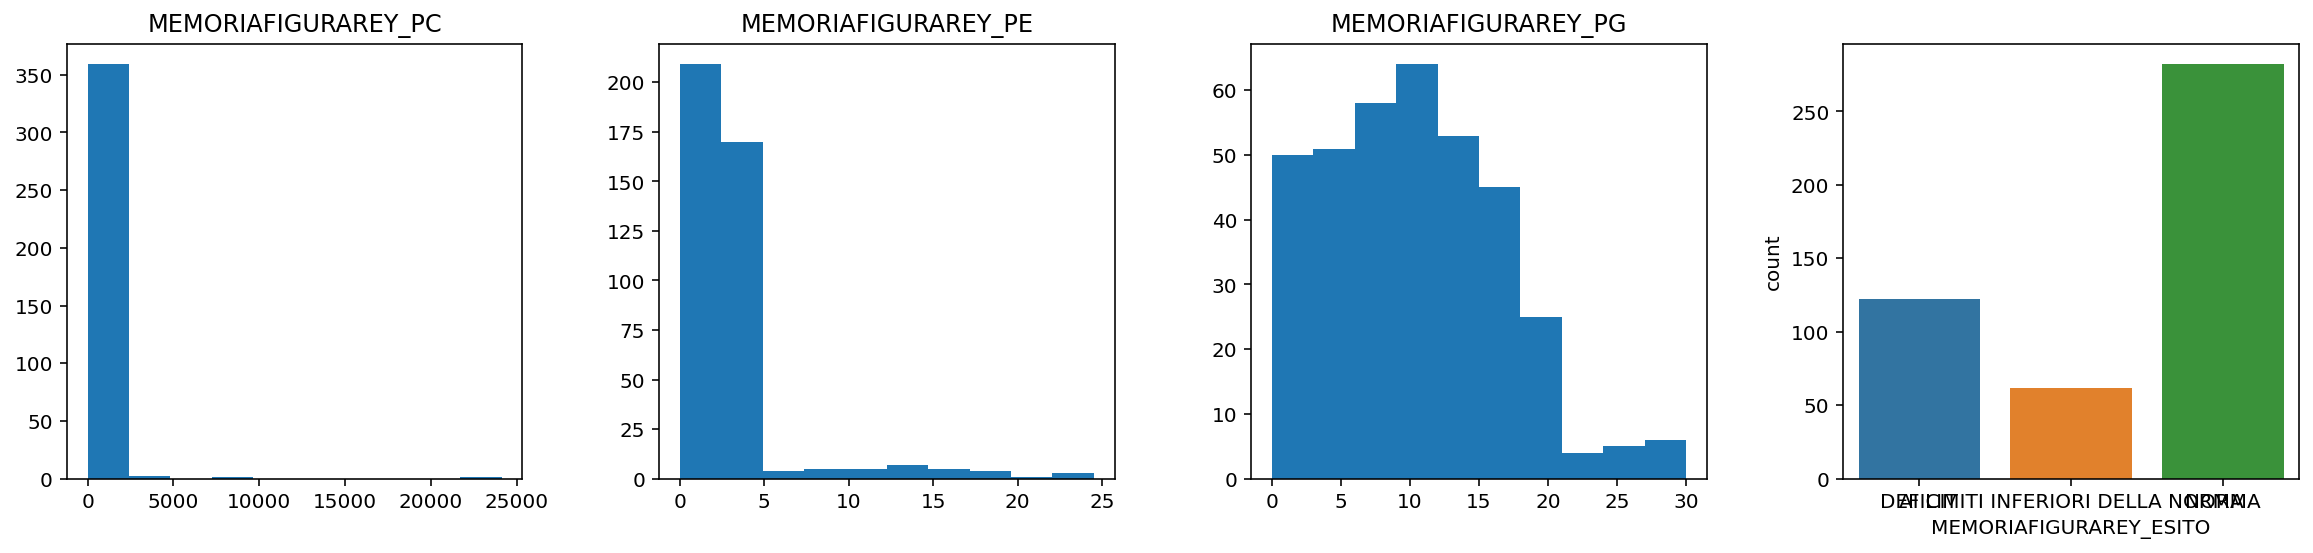

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['MEMORIAFIGURAREY_PG', 'MEMORIAFIGURAREY_PC', 'MEMORIAFIGURAREY_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.MEMORIAFIGURAREY_ESITO, ax=axs[3])
plt.show()

Looking at the dataset we can see not only that lots of MEMORIAFIGURAREY_PC values are missing the comma, but also that, for some entries, attributes of MEMORIAFIGURAREY_PC and MEMORIAFIGURAREY_PE has been swapped.

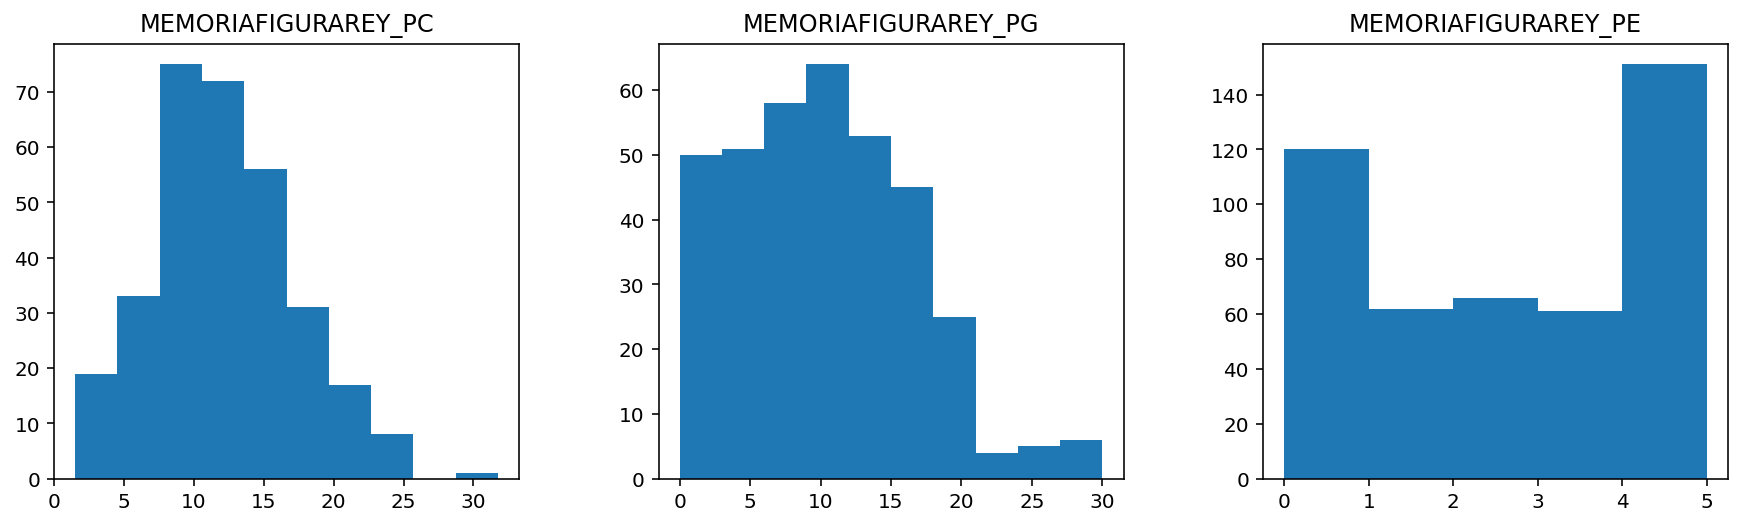

In [25]:
df_clean['MEMORIAFIGURAREY_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean['TEMP_PC'] = df_clean['MEMORIAFIGURAREY_PC'] 
df_clean['TEMP_PE'] = df_clean['MEMORIAFIGURAREY_PE'] 
df_clean.loc[(df_clean.TEMP_PC <= 4) & (df_clean.TEMP_PE > 4), 'MEMORIAFIGURAREY_PC'] = df_clean.TEMP_PE
df_clean.loc[(df_clean.TEMP_PC <= 4) & (df_clean.TEMP_PE > 4), 'MEMORIAFIGURAREY_PE'] = df_clean.TEMP_PC
df_clean.drop(columns=['TEMP_PC', 'TEMP_PE'], inplace=True)
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC <= 4) & (df_clean.MEMORIAFIGURAREY_PE.isnull()), 'MEMORIAFIGURAREY_PE'] = df_clean.MEMORIAFIGURAREY_PC
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC <= 4) & (df_clean.MEMORIAFIGURAREY_PE == df_clean.MEMORIAFIGURAREY_PC), 'MEMORIAFIGURAREY_PC'] = np.NaN
df_clean.loc[df_clean.MEMORIAFIGURAREY_PE > 4, 'MEMORIAFIGURAREY_PE'] = np.NaN

df_clean.loc[df_clean.MEMORIAFIGURAREY_PC > 1000, 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/100
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC > 100) & (df_clean.MEMORIAFIGURAREY_PG >= 5), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/10
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC > 100) & (df_clean.MEMORIAFIGURAREY_PG < 5), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/100
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC > 100) & (df_clean.MEMORIAFIGURAREY_PG.isnull()), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/10
df_clean.loc[df_clean.MEMORIAFIGURAREY_PC > 40, 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/10
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC > 10) & (df_clean.MEMORIAFIGURAREY_PG < 5), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/10
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC > 30) & (df_clean.MEMORIAFIGURAREY_ESITO == 'DEFICIT'), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC/10
df_clean.loc[(df_clean.MEMORIAFIGURAREY_PC < 5) & (df_clean.MEMORIAFIGURAREY_ESITO == 'LIMITI'), 'MEMORIAFIGURAREY_PC'] = df_clean.MEMORIAFIGURAREY_PC*10

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['MEMORIAFIGURAREY_PG', 'MEMORIAFIGURAREY_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['MEMORIAFIGURAREY_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

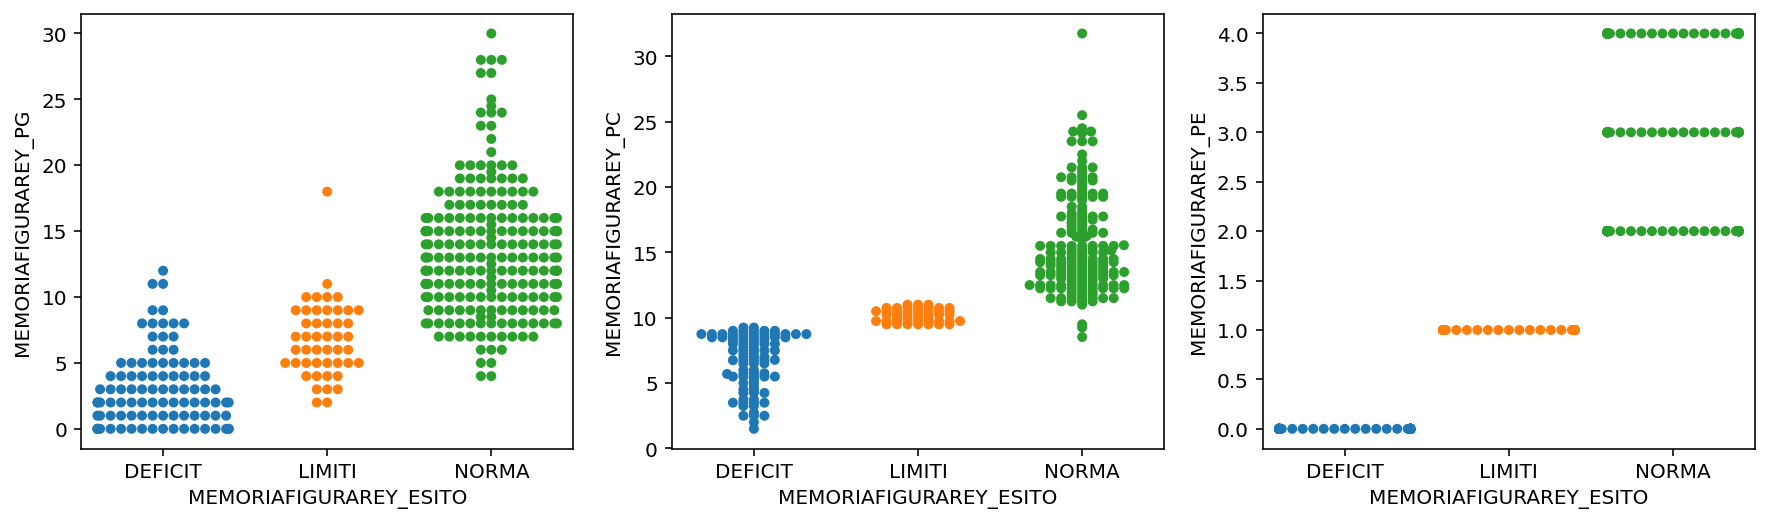

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='MEMORIAFIGURAREY_ESITO', y='MEMORIAFIGURAREY_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='MEMORIAFIGURAREY_ESITO', y='MEMORIAFIGURAREY_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='MEMORIAFIGURAREY_ESITO', y='MEMORIAFIGURAREY_PE', data=df_clean, ax=axs[2])
plt.show()

#### Ray words immediate test
- PAROLEREYIMM_PG range: [0,75]

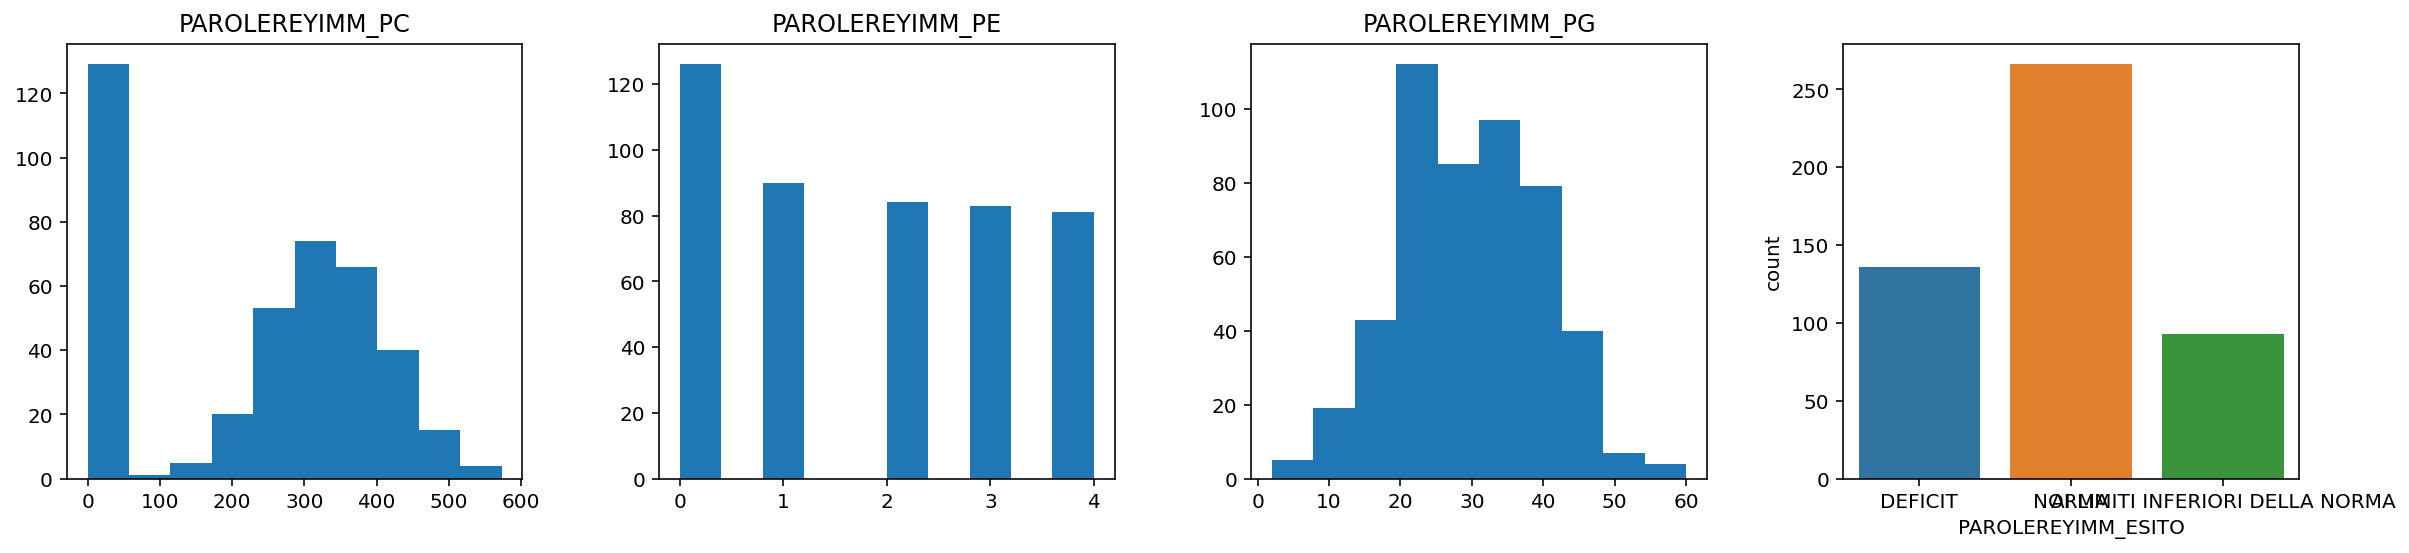

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['PAROLEREYIMM_PG', 'PAROLEREYIMM_PC', 'PAROLEREYIMM_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.PAROLEREYIMM_ESITO, ax=axs[3])
plt.show()

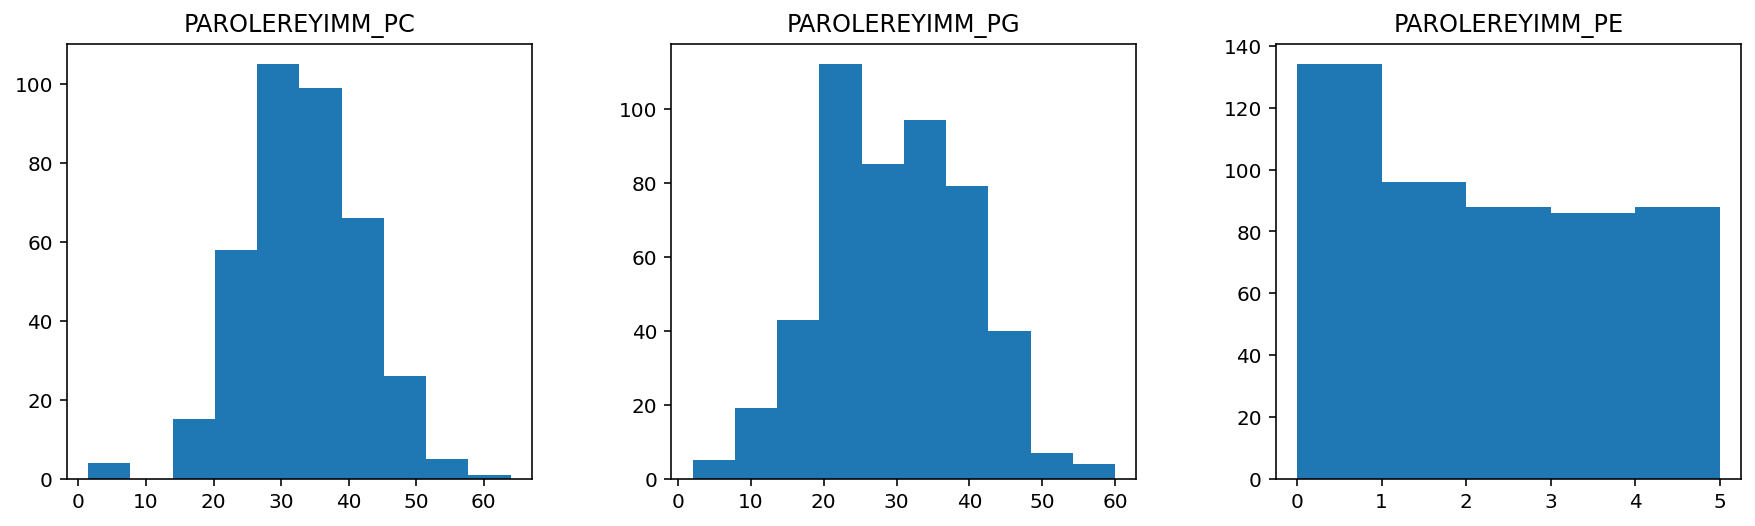

In [28]:
df_clean['PAROLEREYIMM_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean.loc[(df_clean.PAROLEREYIMM_PC > 100) & (df_clean.PAROLEREYIMM_PG >= 10), 'PAROLEREYIMM_PC'] = df_clean.PAROLEREYIMM_PC/10
df_clean.loc[(df_clean.PAROLEREYIMM_PC > 100) & (df_clean.PAROLEREYIMM_PG < 10), 'PAROLEREYIMM_PC'] = df_clean.PAROLEREYIMM_PC/100
df_clean.loc[(df_clean.PAROLEREYIMM_PC > 100) & (df_clean.PAROLEREYIMM_PG.isnull()), 'PAROLEREYIMM_PC'] = df_clean.PAROLEREYIMM_PC/10
df_clean.loc[(df_clean.PAROLEREYIMM_PC > 10) & (df_clean.PAROLEREYIMM_PG < 5), 'PAROLEREYIMM_PC'] = df_clean.PAROLEREYIMM_PC/10

df_clean.loc[(df_clean.PAROLEREYIMM_PC <= 4) & (df_clean.PAROLEREYIMM_PE.isnull()), 'PAROLEREYIMM_PE'] = df_clean.PAROLEREYIMM_PC
df_clean.loc[(df_clean.PAROLEREYIMM_PC <= 4) & (df_clean.PAROLEREYIMM_PE == df_clean.PAROLEREYIMM_PC), 'PAROLEREYIMM_PC'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['PAROLEREYIMM_PG', 'PAROLEREYIMM_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['PAROLEREYIMM_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

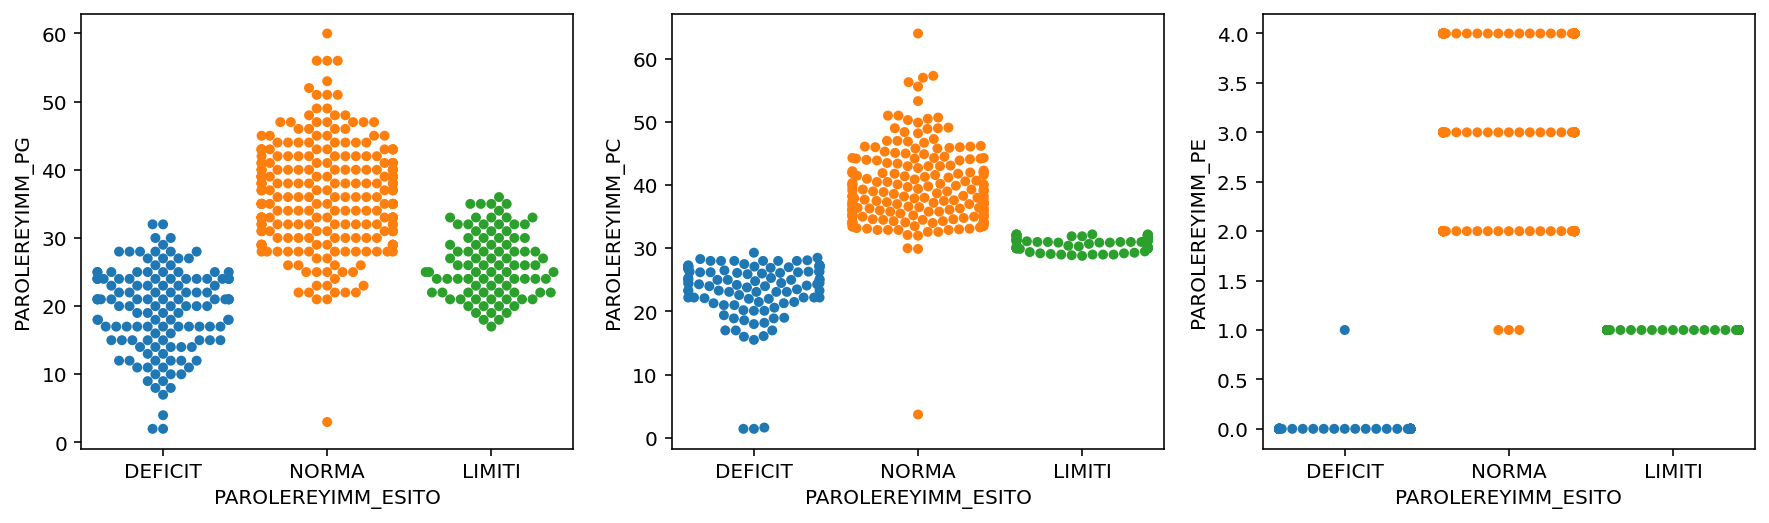

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='PAROLEREYIMM_ESITO', y='PAROLEREYIMM_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='PAROLEREYIMM_ESITO', y='PAROLEREYIMM_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='PAROLEREYIMM_ESITO', y='PAROLEREYIMM_PE', data=df_clean, ax=axs[2])
plt.show()

#### Ray words deferred test
- PAROLEREYDIFF_PG range: [0,15]

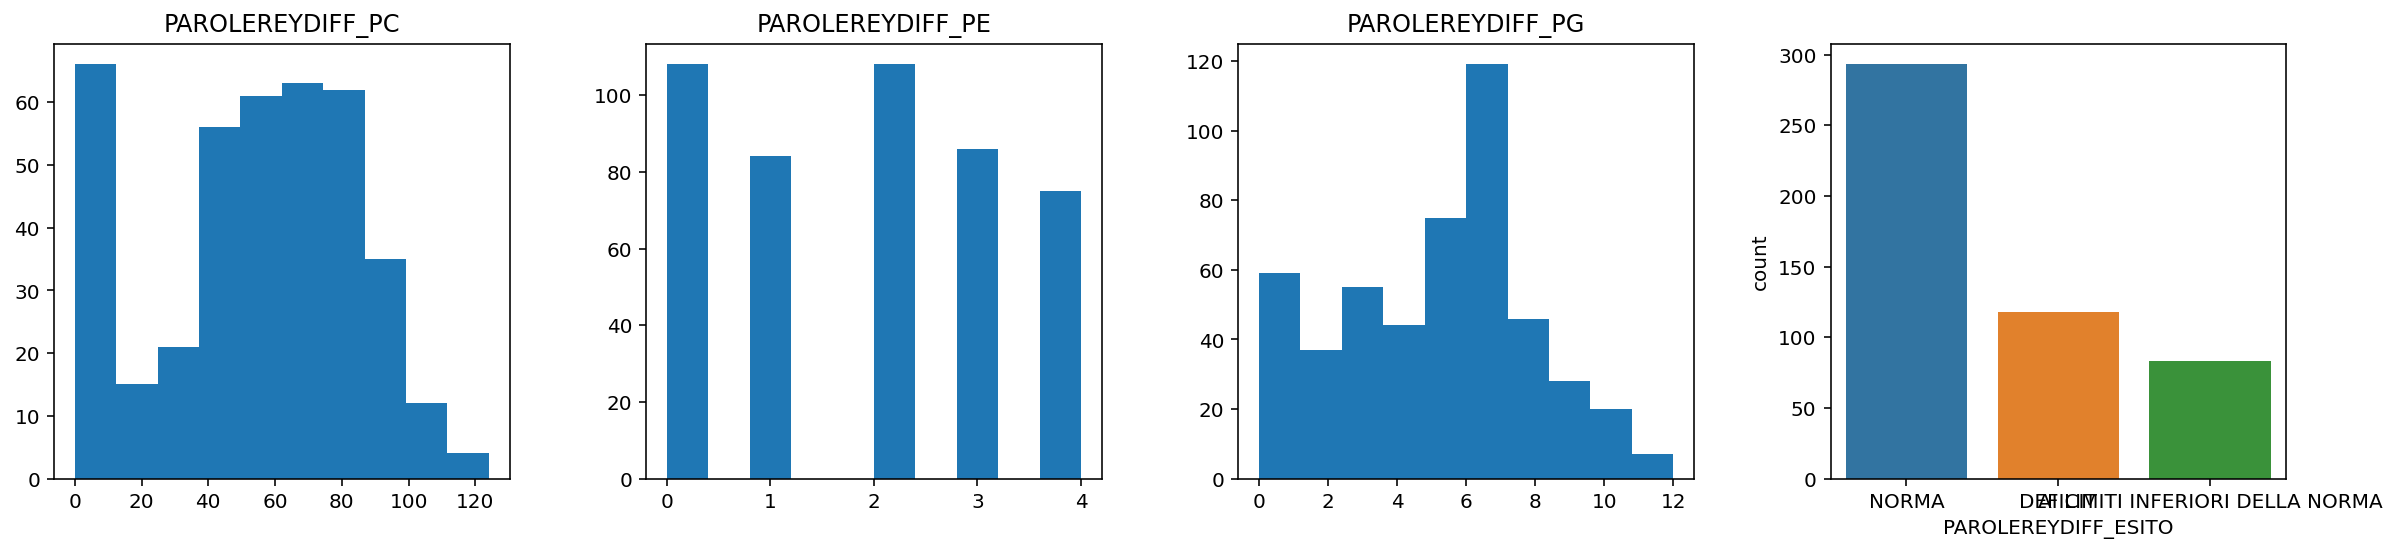

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['PAROLEREYDIFF_PG', 'PAROLEREYDIFF_PC', 'PAROLEREYDIFF_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.PAROLEREYDIFF_ESITO, ax=axs[3])
plt.show()

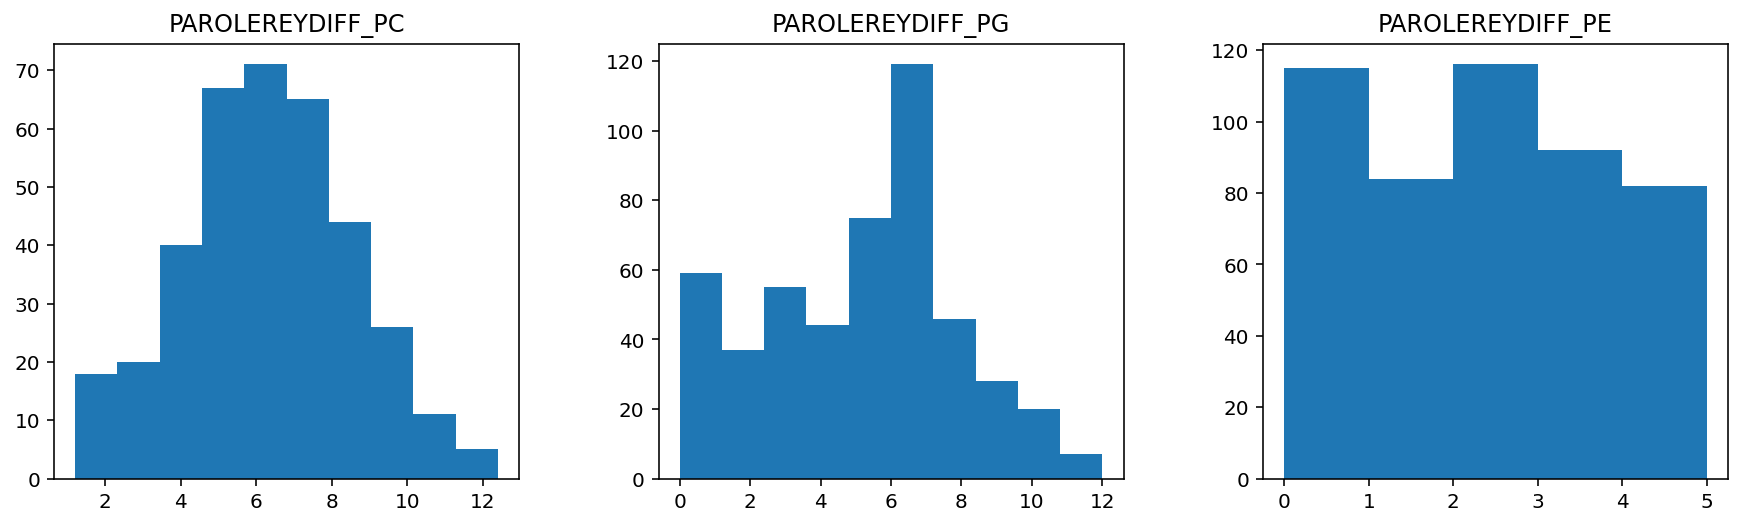

In [31]:
df_clean['PAROLEREYDIFF_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean.loc[(df_clean.PAROLEREYDIFF_PC > 100) & (df_clean.PAROLEREYDIFF_PG > 5), 'PAROLEREYDIFF_PC'] = df_clean.PAROLEREYDIFF_PC/10
df_clean.loc[(df_clean.PAROLEREYDIFF_PC > 100) & (df_clean.PAROLEREYDIFF_PG <= 5), 'PAROLEREYDIFF_PC'] = df_clean.PAROLEREYDIFF_PC/100
df_clean.loc[df_clean.PAROLEREYDIFF_PC > 20, 'PAROLEREYDIFF_PC'] = df_clean.PAROLEREYDIFF_PC/10
df_clean.loc[(df_clean.PAROLEREYDIFF_PC > 6) & (df_clean.PAROLEREYDIFF_PG <= 2), 'PAROLEREYDIFF_PC'] = df_clean.PAROLEREYDIFF_PC/10

df_clean.loc[(df_clean.PAROLEREYDIFF_PC <= 4) & (df_clean.PAROLEREYDIFF_PE.isnull()), 'PAROLEREYDIFF_PE'] = df_clean.PAROLEREYDIFF_PC
df_clean.loc[(df_clean.PAROLEREYDIFF_PC <= 4) & (df_clean.PAROLEREYDIFF_PE == df_clean.PAROLEREYDIFF_PC), 'PAROLEREYDIFF_PC'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['PAROLEREYDIFF_PG', 'PAROLEREYDIFF_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['PAROLEREYDIFF_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

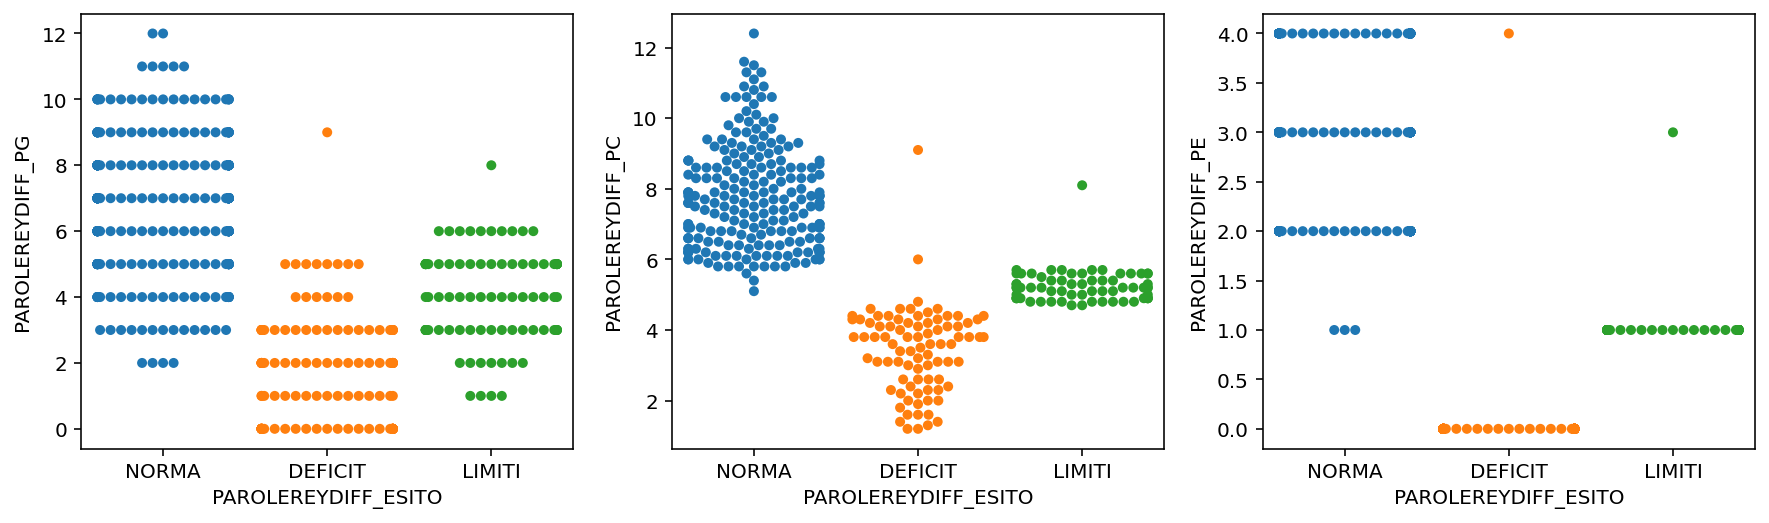

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='PAROLEREYDIFF_ESITO', y='PAROLEREYDIFF_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='PAROLEREYDIFF_ESITO', y='PAROLEREYDIFF_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='PAROLEREYDIFF_ESITO', y='PAROLEREYDIFF_PE', data=df_clean, ax=axs[2])
plt.show()

#### Frontal Assessement Battery (FAB)
- FAB_PG range: [0,18]

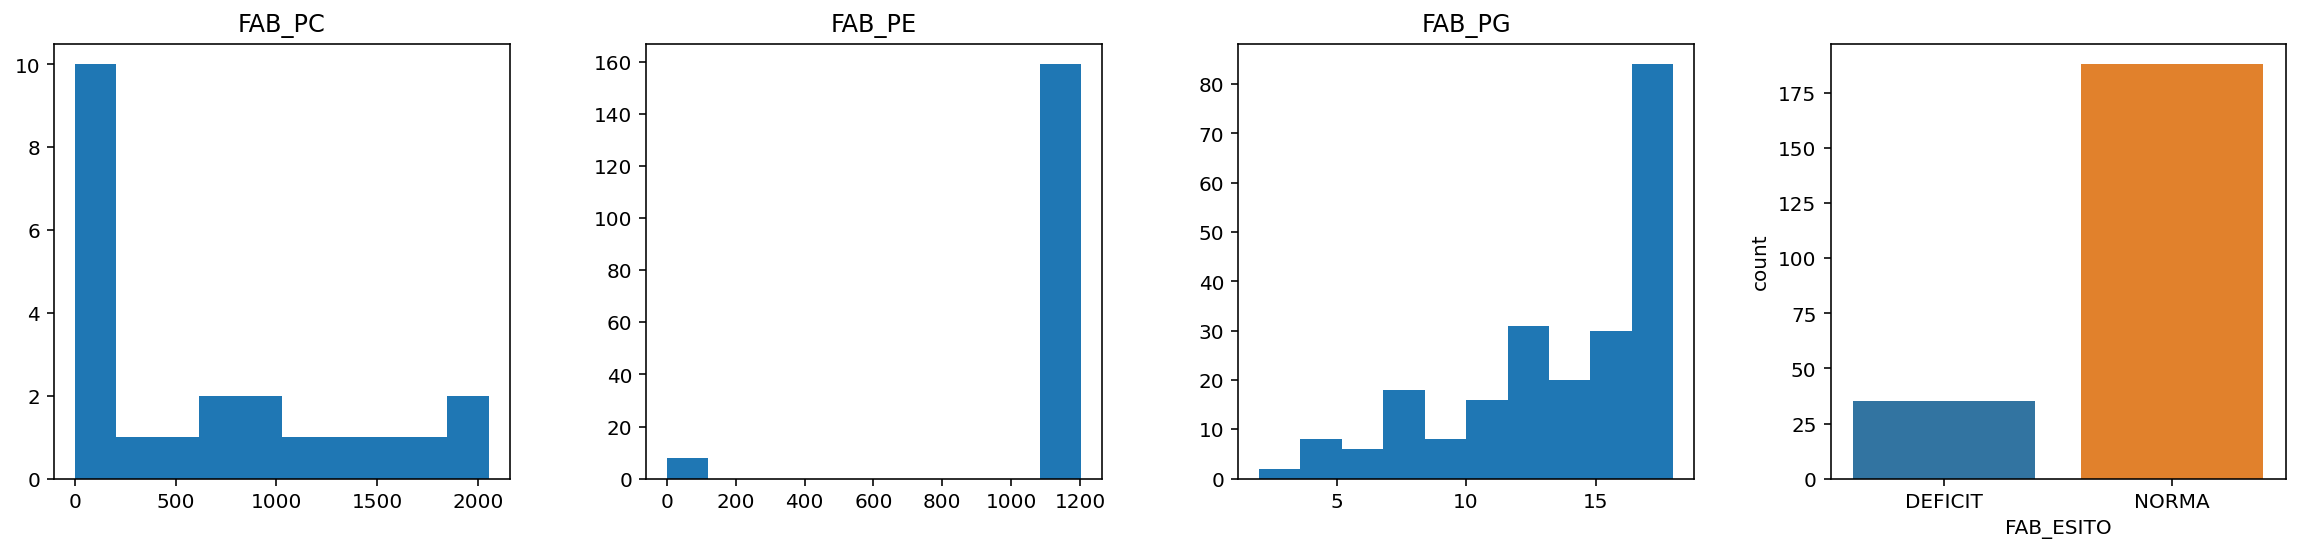

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['FAB_PG', 'FAB_PC', 'FAB_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.FAB_ESITO, ax=axs[3])
plt.show()

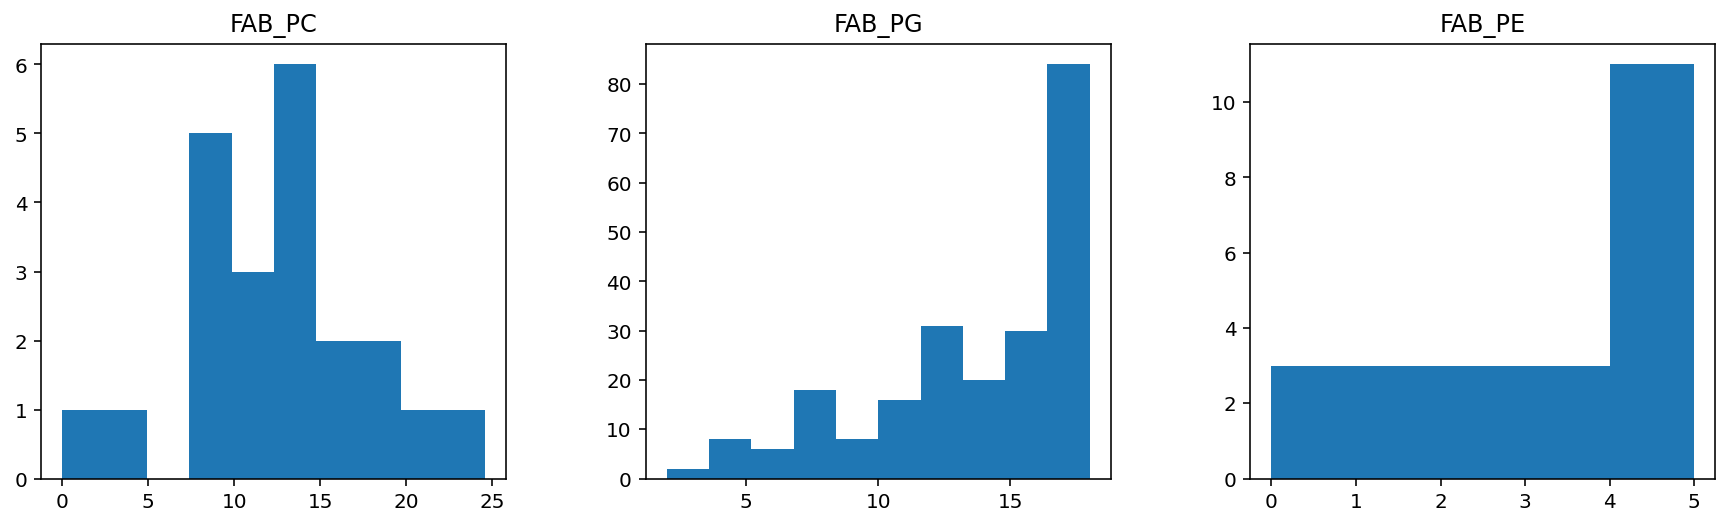

In [34]:
df_clean.loc[df_clean.FAB_PC > 1000 , 'FAB_PC'] = df_clean.FAB_PC/100
df_clean.loc[(df_clean.FAB_PC > 100) & (df_clean.FAB_PG >= 8), 'FAB_PC'] = df_clean.FAB_PC/10
df_clean.loc[(df_clean.FAB_PC > 100) & (df_clean.FAB_PG < 8), 'FAB_PC'] = df_clean.FAB_PC/100

FAB_percentiles = df_clean.describe(percentiles=[.05, .20, .35, .50]).loc[['5%','20%','35%','50%'],['FAB_PC']]

df_clean.loc[df_clean.FAB_PC < FAB_percentiles.loc['5%'].values[0], 'FAB_PE'] = 0
df_clean.loc[(df_clean.FAB_PC >= FAB_percentiles.loc['5%'].values[0]) & (df_clean.FAB_PC < FAB_percentiles.loc['20%'].values[0]), 'FAB_PE'] = 1
df_clean.loc[(df_clean.FAB_PC >= FAB_percentiles.loc['20%'].values[0]) & (df_clean.FAB_PC < FAB_percentiles.loc['35%'].values[0]), 'FAB_PE'] = 2
df_clean.loc[(df_clean.FAB_PC >= FAB_percentiles.loc['35%'].values[0]) & (df_clean.FAB_PC < FAB_percentiles.loc['50%'].values[0]), 'FAB_PE'] = 3
df_clean.loc[(df_clean.FAB_PC >= FAB_percentiles.loc['50%'].values[0]), 'FAB_PE'] = 4
df_clean.loc[df_clean.FAB_PE > 4, 'FAB_PE'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['FAB_PG', 'FAB_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['FAB_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

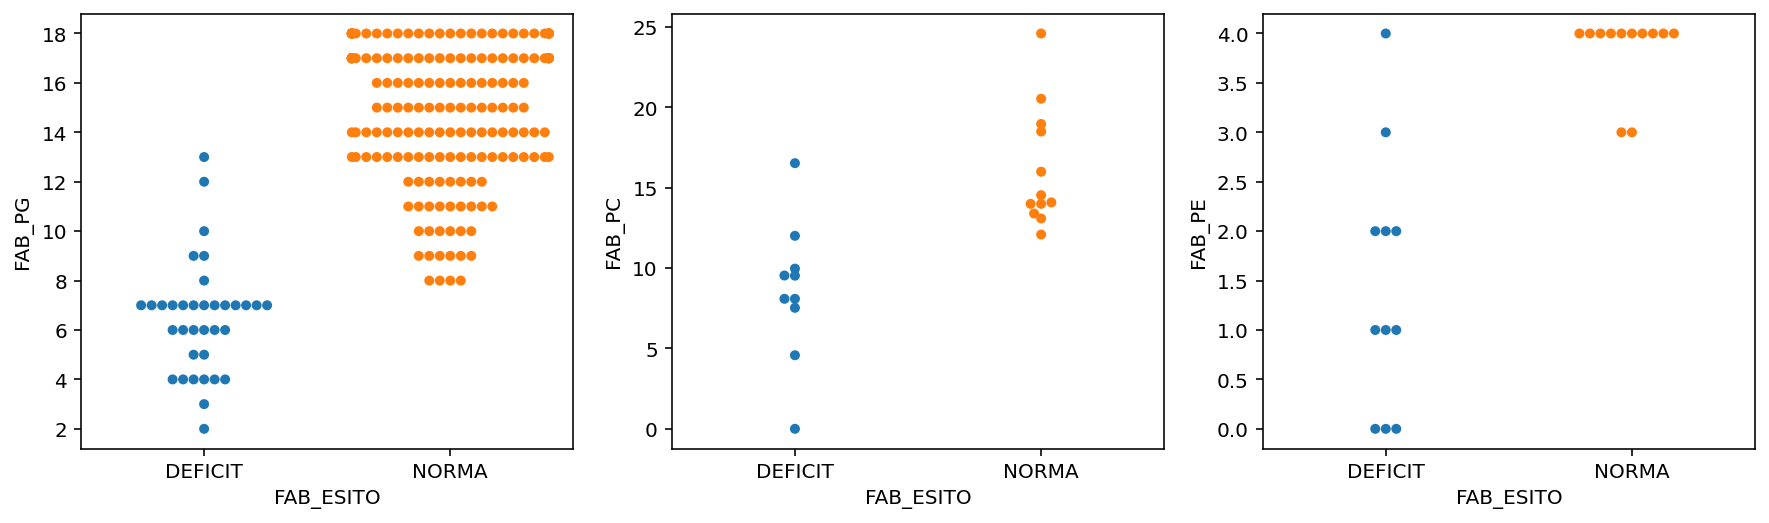

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='FAB_ESITO', y='FAB_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='FAB_ESITO', y='FAB_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='FAB_ESITO', y='FAB_PE', data=df_clean, ax=axs[2])
plt.show()

#### Verbal fluecny
- FLUENZAVERBFON_PG range: [0,~100]

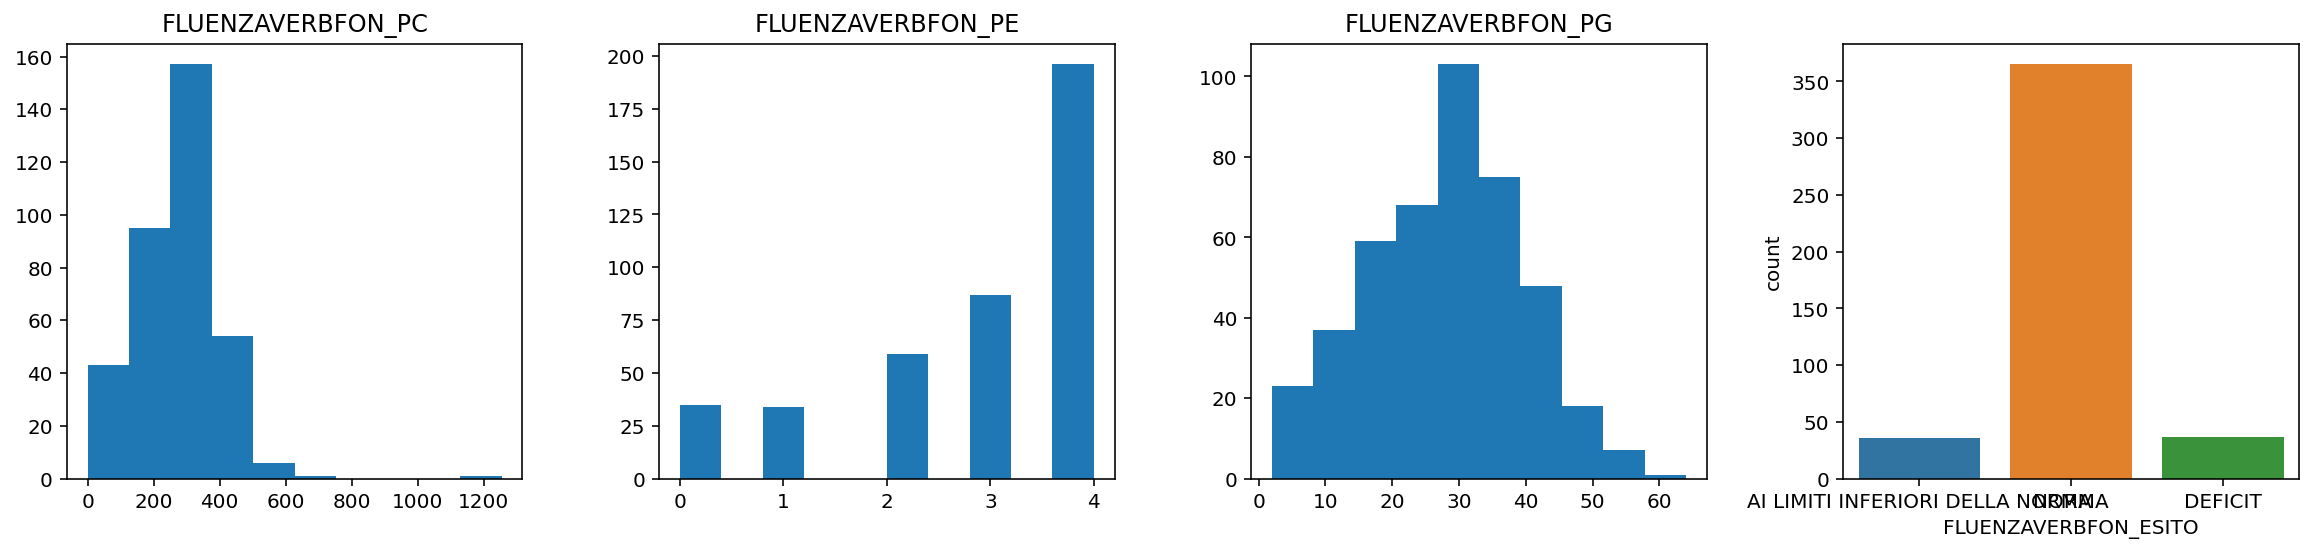

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['FLUENZAVERBFON_PG', 'FLUENZAVERBFON_PC', 'FLUENZAVERBFON_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.FLUENZAVERBFON_ESITO, ax=axs[3])
plt.show()

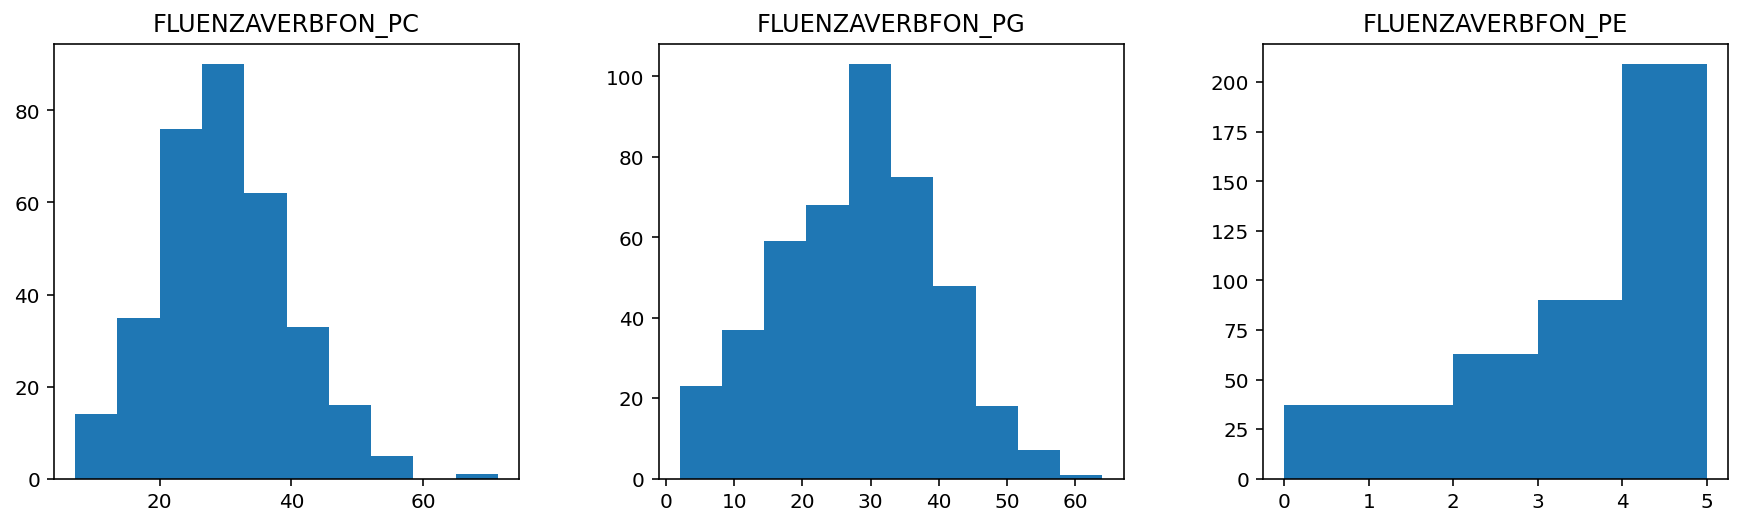

In [37]:
df_clean['FLUENZAVERBFON_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean.loc[(df_clean.FLUENZAVERBFON_PC > 100), 'FLUENZAVERBFON_PC'] = df_clean.FLUENZAVERBFON_PC/10
df_clean.loc[(df_clean.FLUENZAVERBFON_PC > 60) & (df_clean.FLUENZAVERBFON_PG < 20) , 'FLUENZAVERBFON_PC'] = df_clean.FLUENZAVERBFON_PC/10

df_clean.loc[(df_clean.FLUENZAVERBFON_PC <= 4) & (df_clean.FLUENZAVERBFON_PE.isnull()), 'FLUENZAVERBFON_PE'] = df_clean.FLUENZAVERBFON_PC
df_clean.loc[(df_clean.FLUENZAVERBFON_PC <= 4) & (df_clean.FLUENZAVERBFON_PE == df_clean.FLUENZAVERBFON_PC), 'FLUENZAVERBFON_PC'] = np.NaN

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['FLUENZAVERBFON_PG', 'FLUENZAVERBFON_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['FLUENZAVERBFON_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

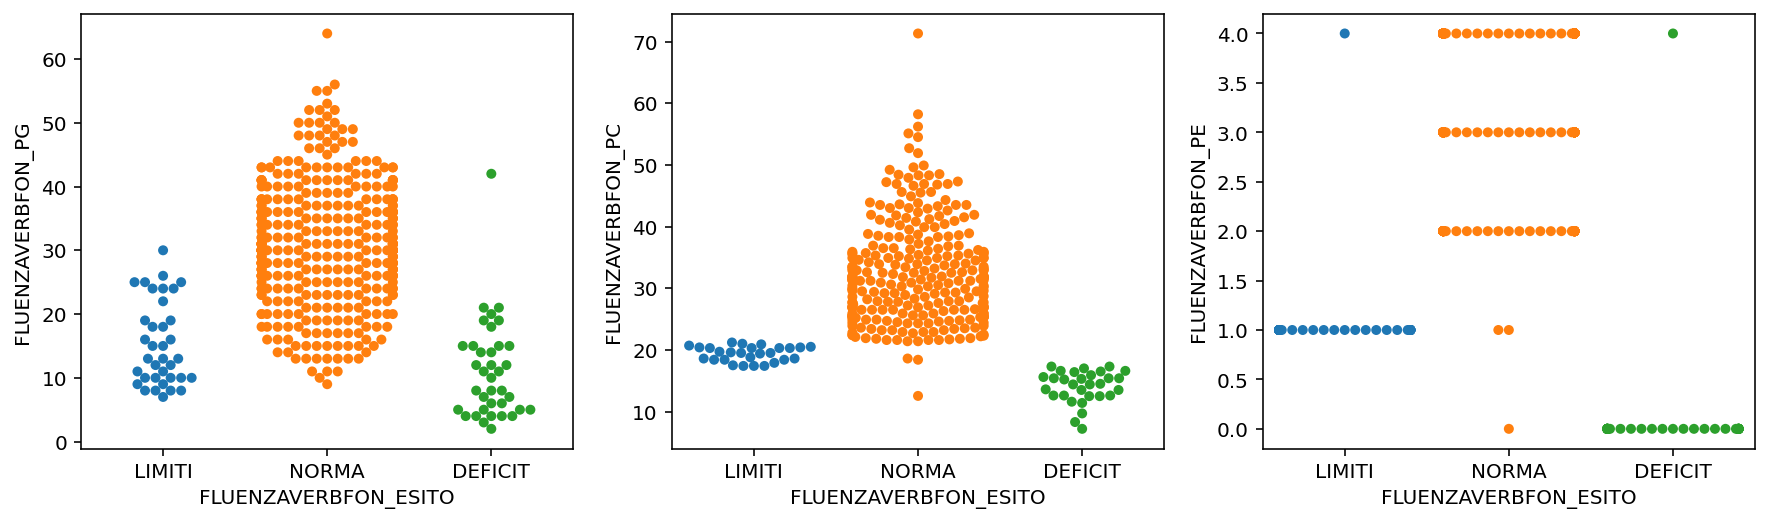

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='FLUENZAVERBFON_ESITO', y='FLUENZAVERBFON_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='FLUENZAVERBFON_ESITO', y='FLUENZAVERBFON_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='FLUENZAVERBFON_ESITO', y='FLUENZAVERBFON_PE', data=df_clean, ax=axs[2])
plt.show()

#### Matrix test
- TESTMATRICIATTENTIVE_PG range: [0,60]

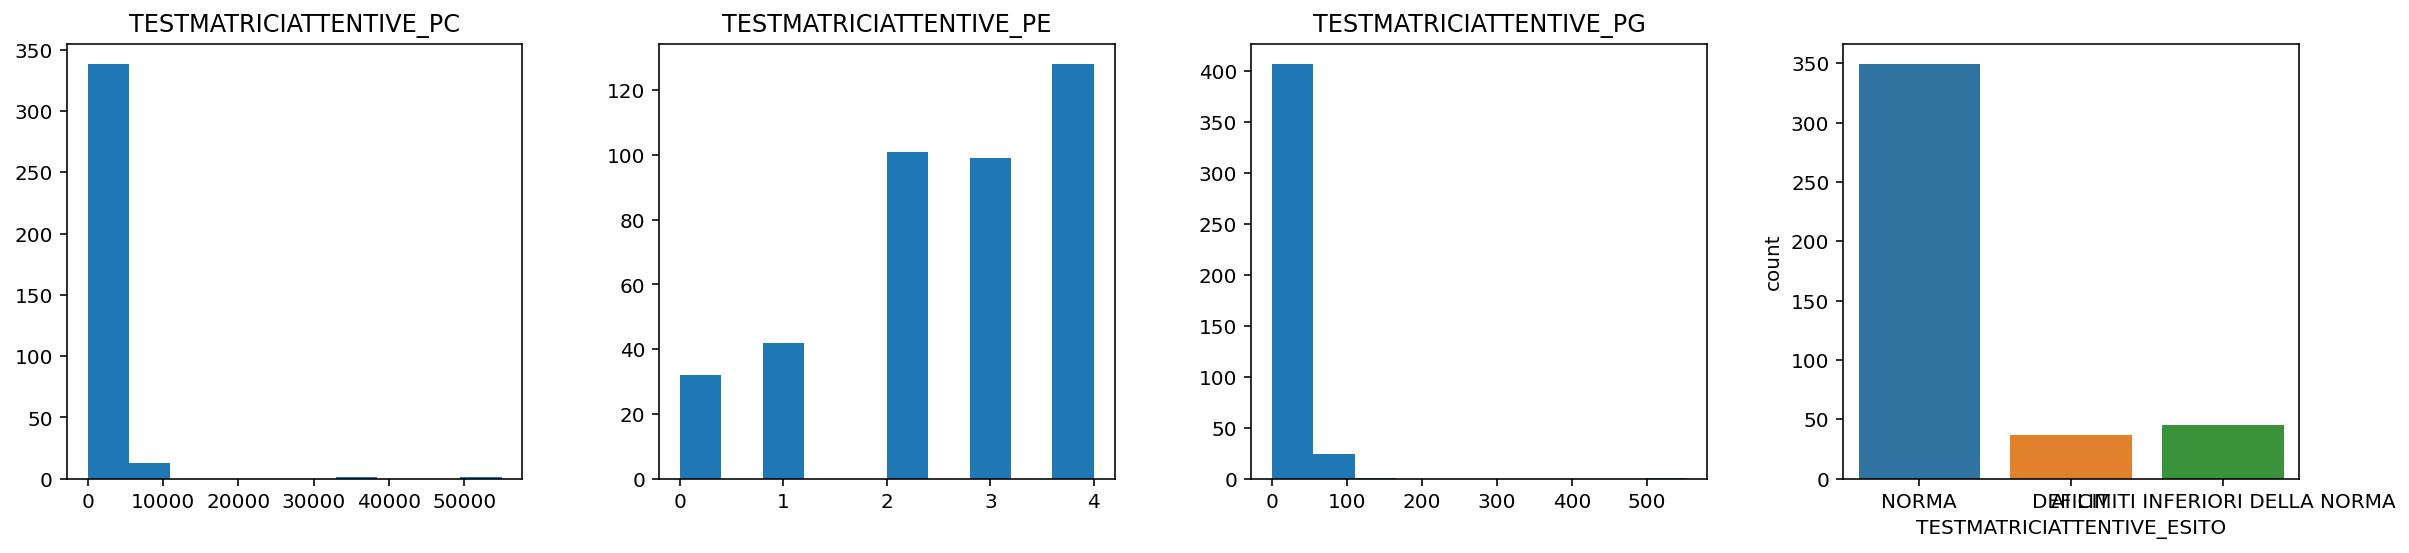

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
df_rough.hist(column=['TESTMATRICIATTENTIVE_PG', 'TESTMATRICIATTENTIVE_PC', 'TESTMATRICIATTENTIVE_PE'], figsize=(10,8), ax=axs[0:3], grid=False)
sns.countplot(df_rough.TESTMATRICIATTENTIVE_ESITO, ax=axs[3])
plt.show()

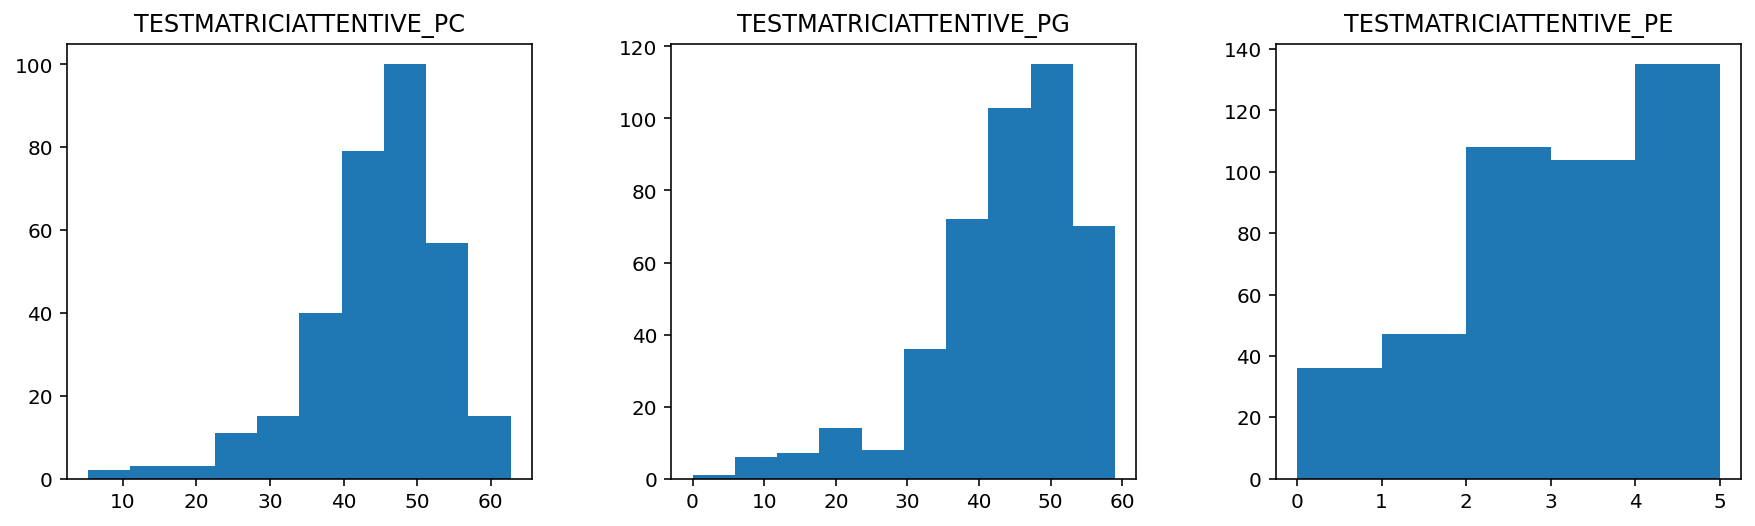

In [40]:
df_clean['TESTMATRICIATTENTIVE_ESITO'].replace(to_replace={'AI LIMITI INFERIORI DELLA NORMA':'LIMITI'}, inplace=True)

df_clean.loc[(df_clean.TESTMATRICIATTENTIVE_PC <= 4) & (df_clean.TESTMATRICIATTENTIVE_PE.isnull()), 'TESTMATRICIATTENTIVE_PE'] = df_clean.TESTMATRICIATTENTIVE_PC
df_clean.loc[(df_clean.TESTMATRICIATTENTIVE_PC <= 4) & (df_clean.TESTMATRICIATTENTIVE_PE == df_clean.TESTMATRICIATTENTIVE_PC), 'TESTMATRICIATTENTIVE_PC'] = np.NaN

df_clean.loc[(df_clean.TESTMATRICIATTENTIVE_PG > 100), 'TESTMATRICIATTENTIVE_PG'] = df_clean.TESTMATRICIATTENTIVE_PG/10
df_clean.loc[df_clean.TESTMATRICIATTENTIVE_PC > 10000, 'TESTMATRICIATTENTIVE_PC'] = df_clean.TESTMATRICIATTENTIVE_PC/1000
df_clean.loc[df_clean.TESTMATRICIATTENTIVE_PC > 1000, 'TESTMATRICIATTENTIVE_PC'] = df_clean.TESTMATRICIATTENTIVE_PC/100
df_clean.loc[(df_clean.TESTMATRICIATTENTIVE_PC > 100) & (df_clean.TESTMATRICIATTENTIVE_PG >= 10), 'TESTMATRICIATTENTIVE_PC'] = df_clean.TESTMATRICIATTENTIVE_PC/10
df_clean.loc[(df_clean.TESTMATRICIATTENTIVE_PC > 100) & (df_clean.TESTMATRICIATTENTIVE_PG < 10), 'TESTMATRICIATTENTIVE_PC'] = df_clean.TESTMATRICIATTENTIVE_PC/100

fig, axs = plt.subplots(1, 3, figsize=(15,4))
df_clean.hist(column=['TESTMATRICIATTENTIVE_PG', 'TESTMATRICIATTENTIVE_PC'], figsize=(10,4), ax=axs[0:2], grid=False)
df_clean.hist(column=['TESTMATRICIATTENTIVE_PE'], figsize=(5,4), bins=np.arange(6), ax=axs[2], grid=False)
plt.show()

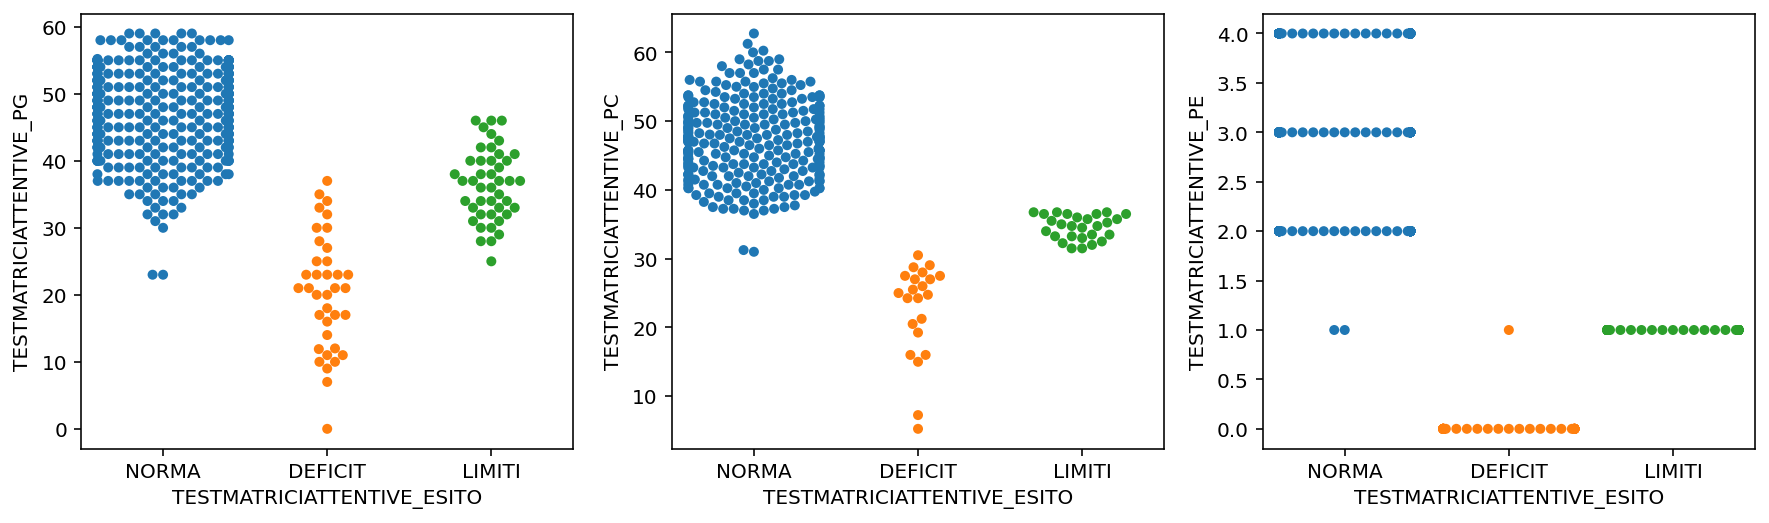

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.swarmplot(x='TESTMATRICIATTENTIVE_ESITO', y='TESTMATRICIATTENTIVE_PG', data=df_clean, ax=axs[0])
sns.swarmplot(x='TESTMATRICIATTENTIVE_ESITO', y='TESTMATRICIATTENTIVE_PC', data=df_clean, ax=axs[1])
sns.swarmplot(x='TESTMATRICIATTENTIVE_ESITO', y='TESTMATRICIATTENTIVE_PE', data=df_clean, ax=axs[2])
plt.show()

#### Pathology
Finally, we can see the class distribution of the training instances.

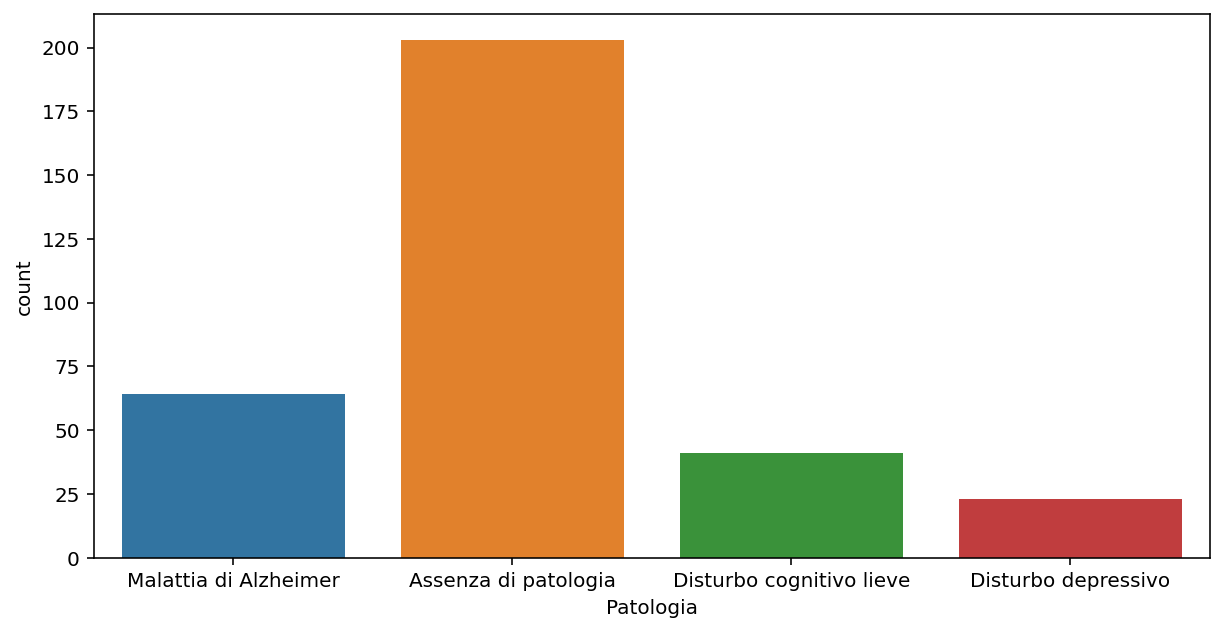

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df_rough.Patologia, ax=ax)
plt.show()

Data seem to be unbalanced, since patients without any pathology are plenty more. This should be taken into account in the modelling. 

### 2.1. Missing values
The last step of preprocessing concern dealing with missing values.

In [43]:
df_miss = df_clean.copy()

In [44]:
df_miss_train = df_miss.merge(df_train_rough, how='right', on='ID', suffixes=[None, 'y'])
df_miss_train = df_miss_train.loc[:,:'Patologia']

#### Scolarity

In [45]:
df_miss.Scolarita.isnull().sum()

16

In [46]:
print('Scolarity mean: ', df_miss_train.Scolarita.median())
print('Scolarity standard deviation: ', df_miss_train.Scolarita.std())

Scolarity mean:  8.0
Scolarity standard deviation:  4.265849252324228


We can fell the missing values of the attribute Scolarita using the median of the column.

In [47]:
df_miss['Scolarita'].fillna(value=df_miss_train.Scolarita.median(), inplace=True)
df_miss.Scolarita.isnull().sum()

0

#### Age

In [48]:
df_miss.Eta.isnull().sum()

137

In [49]:
print('Age mean: ', df_miss_train.Eta.median())
print('Age standard deviation: ', df_miss_train.Eta.std())

Age mean:  69.0
Age standard deviation:  9.674896089355162


We can fell the missing values of the attribute Eta using the median of the column.

In [50]:
df_miss['Eta'].fillna(value=df_miss_train.Eta.median(), inplace=True)
df_miss.Eta.isnull().sum()

0

#### Gender

In [51]:
df_miss.Sesso.isnull().sum()

138

Since we don't want to loose at all the information about patients gender, we can treat the missing value as another possible value of the attribute Sesso.

In [52]:
df_miss.Sesso.replace(to_replace={np.NaN:'N'}, inplace=True)
df_miss.Sesso.unique()

array(['F', 'M', 'N'], dtype=object)

#### Mini Mental State Examination (MMSE)
Let's consider now the attributes related to MMSE. First of all, we count missing values of each of them.

In [53]:
MMSE_features = ['MMSE_PG', 'MMSE_PC', 'MMSE_PE', 'MMSE_ESITO']
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG         7
MMSE_PC       126
MMSE_PE       124
MMSE_ESITO      8
dtype: int64

Except for MMSE_PG, MMSE_ESITO seems to be the feature with less missing value. The basic idea is to use this feature to obtain plausible values for the other features, when they are missing.

We need first to fill missing values of MMSE_ESITO. One way to do that is by using the mode of the attribute, grouped by the class Patologia. In other words, we fill the MMSE_ESITO of a patient with the most frequent value of the class that the patient belong to.

In [54]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['MMSE_ESITO']]
df_mode_ESITO

,MMSE_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,NORMA
Disturbo depressivo,NORMA
Malattia di Alzheimer,NORMA


In [55]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG         7
MMSE_PC       126
MMSE_PE       124
MMSE_ESITO      5
dtype: int64

Of course we can use this strategy only for instances of the training set, for which the class is known. For the test set instances we can just fill missing values with the mode of the column MMSE_ESITO.

In [56]:
df_miss.MMSE_ESITO.fillna(df_miss_train.MMSE_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG         7
MMSE_PC       126
MMSE_PE       124
MMSE_ESITO      0
dtype: int64

Now we can fill the MMSE_PE with the mode of the attribute, grouped by MMSE_ESITO.

In [57]:
df_mode_PE = df_miss_train.groupby('MMSE_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['MMSE_PE']]
df_mode_PE

,MMSE_PE
MMSE_ESITO,
DEFICIT,1.0
LIMITI,NaN
NORMA,4.0


In [58]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.MMSE_ESITO==i, c] = df_miss.loc[df_miss.MMSE_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG         7
MMSE_PC       126
MMSE_PE         1
MMSE_ESITO      0
dtype: int64

In [59]:
df_miss.MMSE_PE.fillna(df_miss_train.MMSE_PE.median(), inplace=True)
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG         7
MMSE_PC       126
MMSE_PE         0
MMSE_ESITO      0
dtype: int64

Of course we can go forward in the same way, filling MMSE_PG and MMSE_PC with the median of each attribute, grouped by MMSE_ESITO. But, to get a more accurate estimated, we can group by MMSE_PE.

In [60]:
df_median = df_miss_train.groupby('MMSE_PE').median().loc[:, ['MMSE_PG', 'MMSE_PC']]
df_median

,MMSE_PG,MMSE_PC
MMSE_PE,,
0.0,17.0,18.990
1.0,22.0,24.015
2.0,27.0,26.480
3.0,28.0,27.460
4.0,29.0,28.875


In [61]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.MMSE_PE==i, c] = df_miss.loc[df_miss.MMSE_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, MMSE_features].isnull().sum()

MMSE_PG       0
MMSE_PC       0
MMSE_PE       0
MMSE_ESITO    0
dtype: int64

As in the cleaning process, we will follow the workflow used for MMSE features for all features of different tests.

#### Clock test

In [62]:
CLOCK_features = ['CLOCKTEST_PG','CLOCKTEST_ESITO']
df_miss.loc[:, CLOCK_features].isnull().sum()

CLOCKTEST_PG       135
CLOCKTEST_ESITO     18
dtype: int64

In [63]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['CLOCKTEST_ESITO']]
df_mode_ESITO

,CLOCKTEST_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,NORMA
Disturbo depressivo,NORMA
Malattia di Alzheimer,NORMA


In [64]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, CLOCK_features].isnull().sum()

CLOCKTEST_PG       135
CLOCKTEST_ESITO     12
dtype: int64

In [65]:
df_miss.CLOCKTEST_ESITO.fillna(df_miss_train.CLOCKTEST_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, CLOCK_features].isnull().sum()

CLOCKTEST_PG       135
CLOCKTEST_ESITO      0
dtype: int64

In [66]:
df_median = df_miss_train.groupby('CLOCKTEST_ESITO').median().loc[:, ['CLOCKTEST_PG']]
df_median

,CLOCKTEST_PG
CLOCKTEST_ESITO,
DEFICIT,1.0
LIMITI,NaN
NORMA,9.0


In [67]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.CLOCKTEST_ESITO==i, c] = df_miss.loc[df_miss.CLOCKTEST_ESITO==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, CLOCK_features].isnull().sum()

CLOCKTEST_PG       1
CLOCKTEST_ESITO    0
dtype: int64

In [68]:
df_miss.CLOCKTEST_PG.fillna(df_miss_train.CLOCKTEST_PG.median(), inplace=True)
df_miss.loc[:, CLOCK_features].isnull().sum()

CLOCKTEST_PG       0
CLOCKTEST_ESITO    0
dtype: int64

#### Ray figure copy test

In [69]:
FIGCOPY_features = ['COPIAFIGURAREY_PG', 'COPIAFIGURAREY_PC', 'COPIAFIGURAREY_PE', 'COPIAFIGURAREY_ESITO']
df_miss.loc[:, FIGCOPY_features].isnull().sum()

COPIAFIGURAREY_PG        88
COPIAFIGURAREY_PC       147
COPIAFIGURAREY_PE        37
COPIAFIGURAREY_ESITO     30
dtype: int64

In [70]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['COPIAFIGURAREY_ESITO']]
df_mode_ESITO

,COPIAFIGURAREY_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,DEFICIT
Disturbo depressivo,DEFICIT
Malattia di Alzheimer,DEFICIT


In [71]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, FIGCOPY_features].isnull().sum()

COPIAFIGURAREY_PG        88
COPIAFIGURAREY_PC       147
COPIAFIGURAREY_PE        37
COPIAFIGURAREY_ESITO     21
dtype: int64

In [72]:
df_miss.COPIAFIGURAREY_ESITO.fillna(df_miss_train.COPIAFIGURAREY_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, FIGCOPY_features].isnull().sum()

COPIAFIGURAREY_PG        88
COPIAFIGURAREY_PC       147
COPIAFIGURAREY_PE        37
COPIAFIGURAREY_ESITO      0
dtype: int64

In [73]:
df_mode_PE = df_miss_train.groupby('COPIAFIGURAREY_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['COPIAFIGURAREY_PE']]
df_mode_PE

,COPIAFIGURAREY_PE
COPIAFIGURAREY_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,4.0


In [74]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.COPIAFIGURAREY_ESITO==i, c] = df_miss.loc[df_miss.COPIAFIGURAREY_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, FIGCOPY_features].isnull().sum()

COPIAFIGURAREY_PG        88
COPIAFIGURAREY_PC       147
COPIAFIGURAREY_PE         0
COPIAFIGURAREY_ESITO      0
dtype: int64

In [75]:
df_median = df_miss_train.groupby('COPIAFIGURAREY_PE').median().loc[:, ['COPIAFIGURAREY_PG', 'COPIAFIGURAREY_PC']]
df_median

,COPIAFIGURAREY_PG,COPIAFIGURAREY_PC
COPIAFIGURAREY_PE,,
0.0,19.0,20.25
1.0,28.0,29.25
2.0,30.0,30.75
3.0,32.0,32.00
4.0,34.0,34.25


In [76]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.COPIAFIGURAREY_PE==i, c] = df_miss.loc[df_miss.COPIAFIGURAREY_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, FIGCOPY_features].isnull().sum()

COPIAFIGURAREY_PG       0
COPIAFIGURAREY_PC       0
COPIAFIGURAREY_PE       0
COPIAFIGURAREY_ESITO    0
dtype: int64

#### Ray figure memory test

In [77]:
FIGMEM_features = ['MEMORIAFIGURAREY_PG', 'MEMORIAFIGURAREY_PC', 'MEMORIAFIGURAREY_PE', 'MEMORIAFIGURAREY_ESITO']
df_miss.loc[:, FIGMEM_features].isnull().sum()

MEMORIAFIGURAREY_PG       150
MEMORIAFIGURAREY_PC       199
MEMORIAFIGURAREY_PE        51
MEMORIAFIGURAREY_ESITO     45
dtype: int64

In [78]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['MEMORIAFIGURAREY_ESITO']]
df_mode_ESITO

,MEMORIAFIGURAREY_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,DEFICIT
Disturbo depressivo,NORMA
Malattia di Alzheimer,DEFICIT


In [79]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, FIGMEM_features].isnull().sum()

MEMORIAFIGURAREY_PG       150
MEMORIAFIGURAREY_PC       199
MEMORIAFIGURAREY_PE        51
MEMORIAFIGURAREY_ESITO     25
dtype: int64

In [80]:
df_miss.MEMORIAFIGURAREY_ESITO.fillna(df_miss_train.MEMORIAFIGURAREY_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, FIGMEM_features].isnull().sum()

MEMORIAFIGURAREY_PG       150
MEMORIAFIGURAREY_PC       199
MEMORIAFIGURAREY_PE        51
MEMORIAFIGURAREY_ESITO      0
dtype: int64

In [81]:
df_mode_PE = df_miss_train.groupby('MEMORIAFIGURAREY_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['MEMORIAFIGURAREY_PE']]
df_mode_PE

,MEMORIAFIGURAREY_PE
MEMORIAFIGURAREY_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,4.0


In [82]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.MEMORIAFIGURAREY_ESITO==i, c] = df_miss.loc[df_miss.MEMORIAFIGURAREY_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, FIGMEM_features].isnull().sum()

MEMORIAFIGURAREY_PG       150
MEMORIAFIGURAREY_PC       199
MEMORIAFIGURAREY_PE         0
MEMORIAFIGURAREY_ESITO      0
dtype: int64

In [83]:
df_median = df_miss_train.groupby('MEMORIAFIGURAREY_PE').median().loc[:, ['MEMORIAFIGURAREY_PG', 'MEMORIAFIGURAREY_PC']]
df_median

,MEMORIAFIGURAREY_PG,MEMORIAFIGURAREY_PC
MEMORIAFIGURAREY_PE,,
0.0,2.0,7.000
1.0,7.0,10.250
2.0,9.0,12.000
3.0,11.0,13.875
4.0,16.0,17.750


In [84]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.MEMORIAFIGURAREY_PE==i, c] = df_miss.loc[df_miss.MEMORIAFIGURAREY_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, FIGMEM_features].isnull().sum()

MEMORIAFIGURAREY_PG       0
MEMORIAFIGURAREY_PC       0
MEMORIAFIGURAREY_PE       0
MEMORIAFIGURAREY_ESITO    0
dtype: int64

#### Ray words immediate test

In [85]:
WORDIMM_features = ['PAROLEREYIMM_PG', 'PAROLEREYIMM_PC', 'PAROLEREYIMM_PE', 'PAROLEREYIMM_ESITO']
df_miss.loc[:, WORDIMM_features].isnull().sum()

PAROLEREYIMM_PG        20
PAROLEREYIMM_PC       132
PAROLEREYIMM_PE        19
PAROLEREYIMM_ESITO     16
dtype: int64

In [86]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['PAROLEREYIMM_ESITO']]
df_mode_ESITO

,PAROLEREYIMM_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,DEFICIT
Disturbo depressivo,NORMA
Malattia di Alzheimer,DEFICIT


In [87]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, WORDIMM_features].isnull().sum()

PAROLEREYIMM_PG        20
PAROLEREYIMM_PC       132
PAROLEREYIMM_PE        19
PAROLEREYIMM_ESITO     10
dtype: int64

In [88]:
df_miss.PAROLEREYIMM_ESITO.fillna(df_miss_train.PAROLEREYIMM_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, WORDIMM_features].isnull().sum()

PAROLEREYIMM_PG        20
PAROLEREYIMM_PC       132
PAROLEREYIMM_PE        19
PAROLEREYIMM_ESITO      0
dtype: int64

In [89]:
df_mode_PE = df_miss_train.groupby('PAROLEREYIMM_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['PAROLEREYIMM_PE']]
df_mode_PE

,PAROLEREYIMM_PE
PAROLEREYIMM_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,2.0


In [90]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.PAROLEREYIMM_ESITO==i, c] = df_miss.loc[df_miss.PAROLEREYIMM_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, WORDIMM_features].isnull().sum()

PAROLEREYIMM_PG        20
PAROLEREYIMM_PC       132
PAROLEREYIMM_PE         0
PAROLEREYIMM_ESITO      0
dtype: int64

In [91]:
df_median = df_miss_train.groupby('PAROLEREYIMM_PE').median().loc[:, ['PAROLEREYIMM_PG', 'PAROLEREYIMM_PC']]
df_median

,PAROLEREYIMM_PG,PAROLEREYIMM_PC
PAROLEREYIMM_PE,,
0.0,20.0,24.5
1.0,25.0,30.9
2.0,29.0,34.6
3.0,37.0,38.7
4.0,43.0,44.4


In [92]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.PAROLEREYIMM_PE==i, c] = df_miss.loc[df_miss.PAROLEREYIMM_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, WORDIMM_features].isnull().sum()

PAROLEREYIMM_PG       0
PAROLEREYIMM_PC       0
PAROLEREYIMM_PE       0
PAROLEREYIMM_ESITO    0
dtype: int64

#### Ray words deferred test

In [93]:
WORDDEFF_features = ['PAROLEREYDIFF_PG', 'PAROLEREYDIFF_PC', 'PAROLEREYDIFF_PE', 'PAROLEREYDIFF_ESITO']
df_miss.loc[:, WORDDEFF_features].isnull().sum()

PAROLEREYDIFF_PG        21
PAROLEREYDIFF_PC       144
PAROLEREYDIFF_PE        22
PAROLEREYDIFF_ESITO     17
dtype: int64

In [94]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['PAROLEREYDIFF_ESITO']]
df_mode_ESITO

,PAROLEREYDIFF_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,DEFICIT
Disturbo depressivo,NORMA
Malattia di Alzheimer,DEFICIT


In [95]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, WORDDEFF_features].isnull().sum()

PAROLEREYDIFF_PG        21
PAROLEREYDIFF_PC       144
PAROLEREYDIFF_PE        22
PAROLEREYDIFF_ESITO     10
dtype: int64

In [96]:
df_miss.PAROLEREYDIFF_ESITO.fillna(df_miss_train.PAROLEREYDIFF_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, WORDDEFF_features].isnull().sum()

PAROLEREYDIFF_PG        21
PAROLEREYDIFF_PC       144
PAROLEREYDIFF_PE        22
PAROLEREYDIFF_ESITO      0
dtype: int64

In [97]:
df_mode_PE = df_miss_train.groupby('PAROLEREYDIFF_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['PAROLEREYDIFF_PE']]
df_mode_PE

,PAROLEREYDIFF_PE
PAROLEREYDIFF_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,2.0


In [98]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.PAROLEREYDIFF_ESITO==i, c] = df_miss.loc[df_miss.PAROLEREYDIFF_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, WORDDEFF_features].isnull().sum()

PAROLEREYDIFF_PG        21
PAROLEREYDIFF_PC       144
PAROLEREYDIFF_PE         0
PAROLEREYDIFF_ESITO      0
dtype: int64

In [99]:
df_median = df_miss_train.groupby('PAROLEREYDIFF_PE').median().loc[:, ['PAROLEREYDIFF_PG', 'PAROLEREYDIFF_PC']]
df_median

,PAROLEREYDIFF_PG,PAROLEREYDIFF_PC
PAROLEREYDIFF_PE,,
0.0,2.0,3.6
1.0,4.0,5.2
2.0,5.0,6.3
3.0,7.0,7.8
4.0,9.0,9.6


In [100]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.PAROLEREYDIFF_PE==i, c] = df_miss.loc[df_miss.PAROLEREYDIFF_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, WORDDEFF_features].isnull().sum()

PAROLEREYDIFF_PG       0
PAROLEREYDIFF_PC       0
PAROLEREYDIFF_PE       0
PAROLEREYDIFF_ESITO    0
dtype: int64

#### Frontal Assessement Battery (FAB)

In [101]:
FAB_features = ['FAB_PG', 'FAB_PC', 'FAB_PE', 'FAB_ESITO']
df_miss.loc[:, FAB_features].isnull().sum()

FAB_PG       288
FAB_PC       489
FAB_PE       488
FAB_ESITO    288
dtype: int64

We can notice that missing values for FAB features are many more, compared to other tests. For this reason, we may conclude that FAB features should be discarded from the dataset.

#### Verbal fluency

In [102]:
VERB_features = ['FLUENZAVERBFON_PG', 'FLUENZAVERBFON_PC', 'FLUENZAVERBFON_PE', 'FLUENZAVERBFON_ESITO']
df_miss.loc[:, VERB_features].isnull().sum()

FLUENZAVERBFON_PG        72
FLUENZAVERBFON_PC       179
FLUENZAVERBFON_PE        75
FLUENZAVERBFON_ESITO     73
dtype: int64

In [103]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['FLUENZAVERBFON_ESITO']]
df_mode_ESITO

,FLUENZAVERBFON_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,NORMA
Disturbo depressivo,NORMA
Malattia di Alzheimer,NORMA


In [104]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, VERB_features].isnull().sum()

FLUENZAVERBFON_PG        72
FLUENZAVERBFON_PC       179
FLUENZAVERBFON_PE        75
FLUENZAVERBFON_ESITO     29
dtype: int64

In [105]:
df_miss.FLUENZAVERBFON_ESITO.fillna(df_miss_train.FLUENZAVERBFON_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, VERB_features].isnull().sum()

FLUENZAVERBFON_PG        72
FLUENZAVERBFON_PC       179
FLUENZAVERBFON_PE        75
FLUENZAVERBFON_ESITO      0
dtype: int64

In [106]:
df_mode_PE = df_miss_train.groupby('FLUENZAVERBFON_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['FLUENZAVERBFON_PE']]
df_mode_PE

,FLUENZAVERBFON_PE
FLUENZAVERBFON_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,4.0


In [107]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.FLUENZAVERBFON_ESITO==i, c] = df_miss.loc[df_miss.FLUENZAVERBFON_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, VERB_features].isnull().sum()

FLUENZAVERBFON_PG        72
FLUENZAVERBFON_PC       179
FLUENZAVERBFON_PE         0
FLUENZAVERBFON_ESITO      0
dtype: int64

In [108]:
df_median = df_miss_train.groupby('FLUENZAVERBFON_PE').median().loc[:, ['FLUENZAVERBFON_PG', 'FLUENZAVERBFON_PC']]
df_median

,FLUENZAVERBFON_PG,FLUENZAVERBFON_PC
FLUENZAVERBFON_PE,,
0.0,11.0,13.1
1.0,13.0,19.5
2.0,19.5,23.3
3.0,26.0,27.2
4.0,36.0,36.4


In [109]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.FLUENZAVERBFON_PE==i, c] = df_miss.loc[df_miss.FLUENZAVERBFON_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, VERB_features].isnull().sum()

FLUENZAVERBFON_PG       0
FLUENZAVERBFON_PC       0
FLUENZAVERBFON_PE       0
FLUENZAVERBFON_ESITO    0
dtype: int64

#### Matrix test

In [110]:
MATRIX_features = ['TESTMATRICIATTENTIVE_PG', 'TESTMATRICIATTENTIVE_PC', 'TESTMATRICIATTENTIVE_PE', 'TESTMATRICIATTENTIVE_ESITO']
df_miss.loc[:, MATRIX_features].isnull().sum()

TESTMATRICIATTENTIVE_PG        79
TESTMATRICIATTENTIVE_PC       186
TESTMATRICIATTENTIVE_PE        81
TESTMATRICIATTENTIVE_ESITO     80
dtype: int64

In [111]:
df_mode_ESITO = df_miss_train.groupby('Patologia').apply(lambda x: x.mode().iloc[0]).loc[:, ['TESTMATRICIATTENTIVE_ESITO']]
df_mode_ESITO

,TESTMATRICIATTENTIVE_ESITO
Patologia,
Assenza di patologia,NORMA
Disturbo cognitivo lieve,NORMA
Disturbo depressivo,NORMA
Malattia di Alzheimer,NORMA


In [112]:
for i in df_mode_ESITO.index:
    for c in df_mode_ESITO.columns:
        df_miss.loc[df_miss.Patologia==i, c] = df_miss.loc[df_miss.Patologia==i, c].fillna(df_mode_ESITO.loc[i][0])     
df_miss.loc[:, MATRIX_features].isnull().sum()

TESTMATRICIATTENTIVE_PG        79
TESTMATRICIATTENTIVE_PC       186
TESTMATRICIATTENTIVE_PE        81
TESTMATRICIATTENTIVE_ESITO     33
dtype: int64

In [113]:
df_miss.TESTMATRICIATTENTIVE_ESITO.fillna(df_miss_train.TESTMATRICIATTENTIVE_ESITO.mode().iloc[0], inplace=True)
df_miss.loc[:, MATRIX_features].isnull().sum()

TESTMATRICIATTENTIVE_PG        79
TESTMATRICIATTENTIVE_PC       186
TESTMATRICIATTENTIVE_PE        81
TESTMATRICIATTENTIVE_ESITO      0
dtype: int64

In [114]:
df_mode_PE = df_miss_train.groupby('TESTMATRICIATTENTIVE_ESITO').apply(lambda x: x.mode().iloc[0]).loc[:, ['TESTMATRICIATTENTIVE_PE']]
df_mode_PE

,TESTMATRICIATTENTIVE_PE
TESTMATRICIATTENTIVE_ESITO,
DEFICIT,0.0
LIMITI,1.0
NORMA,4.0


In [115]:
for i in df_mode_PE.index:
    for c in df_mode_PE.columns:
        df_miss.loc[df_miss.TESTMATRICIATTENTIVE_ESITO==i, c] = df_miss.loc[df_miss.TESTMATRICIATTENTIVE_ESITO==i, c].fillna(df_mode_PE.loc[i][0])     
df_miss.loc[:, MATRIX_features].isnull().sum()

TESTMATRICIATTENTIVE_PG        79
TESTMATRICIATTENTIVE_PC       186
TESTMATRICIATTENTIVE_PE         0
TESTMATRICIATTENTIVE_ESITO      0
dtype: int64

In [116]:
df_median = df_miss_train.groupby('TESTMATRICIATTENTIVE_PE').median().loc[:, ['TESTMATRICIATTENTIVE_PG', 'TESTMATRICIATTENTIVE_PC']]
df_median

,TESTMATRICIATTENTIVE_PG,TESTMATRICIATTENTIVE_PC
TESTMATRICIATTENTIVE_PE,,
0.0,21.0,26.500
1.0,37.0,34.500
2.0,41.0,41.250
3.0,47.0,46.625
4.0,53.0,52.500


In [117]:
for i in df_median.index:
    for c in df_median.columns:
        df_miss.loc[df_miss.TESTMATRICIATTENTIVE_PE==i, c] = df_miss.loc[df_miss.TESTMATRICIATTENTIVE_PE==i, c].fillna(df_median.loc[i, c])     
df_miss.loc[:, MATRIX_features].isnull().sum()

TESTMATRICIATTENTIVE_PG       0
TESTMATRICIATTENTIVE_PC       0
TESTMATRICIATTENTIVE_PE       0
TESTMATRICIATTENTIVE_ESITO    0
dtype: int64

#### Pathology

In [118]:
df_miss.loc[:, 'Patologia'].isnull().sum()

180

In [119]:
df_test_rough.shape

(164, 40)

In [120]:
df_train_rough.loc[:, 'Patologia'].isnull().sum()

16

The last funny thing that we can notice is that some entries of training set are missing the class label. There is no point in keeping them.

## 3. Modelling
Completed the preprocessing stage, we can start seeking the best model for our classification problem.

In [121]:
df_model = df_miss.copy()

We need to split again our dataset in training and test set. The former will be used for building the model. The latter will be used to create the submission for the contest.

In [122]:
df_train = df_model.dropna(subset=['Patologia']).copy()

df_test = df_model.merge(df_test_rough, how='right', on='ID', suffixes=[None, 'y'])
df_test = df_test.loc[:,:'Patologia']
df_test.drop(columns=['Patologia'], inplace=True)

### 3.1. Feature selection
A key step of the modeling stage is the so called feature selection. We need to define the features that will be used as input to our model, since not all them may be valuable.

In these section we won't use any formal technique of feature selection, such as *filter approach* or *wrapper method*, because is out of the aim of this contest. We will restrict ourselves to select attributes based on the observations that we made during the preprocessing stage.

According to what we said before, let's drop CLOCKTEST_PE and the features related to FAB test.

In [123]:
df_train.drop(columns=['CLOCKTEST_PE', 'FAB_PG', 'FAB_PC', 'FAB_PE', 'FAB_ESITO'], inplace=True)
df_test.drop(columns=['CLOCKTEST_PE', 'FAB_PG', 'FAB_PC', 'FAB_PE', 'FAB_ESITO'], inplace=True)

Another feature that can be easily discard is the CAP, since it doesn't contain useful information about cognitive abilities of the patients.

In [124]:
df_train.drop(columns=['CAP'], inplace=True)
df_test.drop(columns=['CAP'], inplace=True)

Feature of the same test (PG, PC, PE and ESITO) are strongly correlated, so it would be worthless to consider all of them. We choose to keep PG, since it is usually the one with few missing values, and PC, since it takes into account also scolarity and age of a patient.

In [125]:
features = ['MMSE_PG', 'MMSE_PC',
            'CLOCKTEST_PG',
            'COPIAFIGURAREY_PG', 'COPIAFIGURAREY_PC',
            'PAROLEREYIMM_PG', 'PAROLEREYIMM_PC',
            'PAROLEREYDIFF_PG', 'PAROLEREYDIFF_PC',
            'MEMORIAFIGURAREY_PG', 'MEMORIAFIGURAREY_PC',
            'FLUENZAVERBFON_PG', 'FLUENZAVERBFON_PC',
            'TESTMATRICIATTENTIVE_PG', 'TESTMATRICIATTENTIVE_PC']

Moreover, we won't consider scolarity and age, because information of both feature is somehow embedded in PC values. On the other hand, we want to keep information about patients gender. 

Since most of the models don't deal with categorical attribute, let's encode the gender column using a **one hot encoding** approach:

| sex | sex_M | sex_F | sex_N |
| --- | --- | --- | --- |
| M | 1 | 0 | 0 |
| F | 0 | 1 | 0 |
| N | 0 | 0 | 1 |

In [126]:
df_train = pd.get_dummies(df_train, columns=['Sesso'])
df_test = pd.get_dummies(df_test, columns=['Sesso'])

In [127]:
features = features + ['Sesso_F', 'Sesso_M', 'Sesso_N']

### 3.2. Model selection
Selected the features, we can perform model section, a process aimed at finding the best model for our problem. For this purpose, we use a techinique called **nested cross validation**, which include two cross validation at different level:
- *outer cross validation*: 10-fold stratified cross validation, used to evaluate the overall performance of the model. We used stratification to ensure that each fold preserve the percentage of samples for each class. Where possible, in term of  computational complexity, we repeated the entire process 10 times, reaching a 10 times 10-fold cross validation.
- *inner cross validation*: 2-fold statified cross validation, used to apply hyperparameters optimization within each fold of the outer cross validation.

It should be stressed that nested cross validation is not used for determining the best hyperparameters, since they may vary from fold to fold, but to evaluate the overall learning process of the model.

#### Decision Tree

In [128]:
X = df_train[features].values
y = df_train.Patologia.values

outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

tree = DecisionTreeClassifier()

parameters = {'criterion':['gini', 'entropy'], 'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_leaf':[2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'class_weight':[None, 'balanced']}

clf = GridSearchCV(estimator=tree, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=inner_cv)
clf.fit(X, y)
inner_best_scores = clf.best_score_
inner_best_param = clf.best_params_

nested_score = cross_val_score(clf, X=X, y=y, scoring=make_scorer(accuracy_score), cv=outer_cv)

# print(nested_score)
print('Decision Tree accuracy:', nested_score.mean())

Decision Tree accuracy:  0.7021122994652409


#### K-Nearest Neighbors (KNN)

In [129]:
X = df_train[features].values
y = df_train.Patologia.values

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

knn = KNeighborsClassifier()

parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights':['uniform', 'distance']}

clf = GridSearchCV(estimator=knn, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=inner_cv)
clf.fit(X, y)
inner_best_scores = clf.best_score_
inner_best_param = clf.best_params_

nested_score = cross_val_score(clf, X=X, y=y, scoring=make_scorer(accuracy_score), cv=outer_cv)

# print(nested_score)
print('KNN accuracy:', nested_score.mean())

KNN accuracy:  0.7504812834224601


#### Logistic Regression

In [130]:
X = df_train[features].values
y = df_train.Patologia.values

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

reg = LogisticRegression()

parameters = {'C':[0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8], 'solver':['newton-cg', 'lbfgs', 'liblinear'], 'max_iter':[200, 400], 'class_weight':['balanced', None]}

clf = GridSearchCV(estimator=reg, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=inner_cv)
clf.fit(X, y)
inner_best_scores = clf.best_score_
inner_best_param = clf.best_params_

nested_score = cross_val_score(clf, X=X, y=y, scoring=make_scorer(accuracy_score), cv=outer_cv)

# print(nested_score)
print('Logistic Regression accuracy:', nested_score.mean())

Logistic Regression accuracy:  0.7461675579322639


#### Support Vector Machine (SVM)

In [131]:
X = df_train[features].values
y = df_train.Patologia.values

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

svm = SVC()

parameters = {'C':[0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8], 'kernel':['linear', 'rbf', 'poly'], 'class_weight':['balanced', None]}

clf = GridSearchCV(estimator=svm, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=inner_cv)
clf.fit(X, y)
inner_best_scores = clf.best_score_
inner_best_param = clf.best_params_

nested_score = cross_val_score(clf, X=X, y=y, scoring=make_scorer(accuracy_score), cv=outer_cv)

# print(nested_score)
print('SVM accuracy:', nested_score.mean())

SVM accuracy:  0.7631818181818183


#### Multi Layer Perceptron (MLP)

In [132]:
X = df_train[features].values
y = df_train.Patologia.values

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

outer_cv = StratifiedKFold(n_splits=10, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

mlp = MLPClassifier()

parameters = {'activation':['logistic', 'relu'], 'solver':['adam', 'lbfgs'], 'learning_rate':['constant', 'adaptive'], 'max_iter':[200, 400], 'early_stopping':[True, False]}

clf = GridSearchCV(estimator=mlp, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=inner_cv)
clf.fit(X, y)
inner_best_scores = clf.best_score_
inner_best_param = clf.best_params_

nested_score = cross_val_score(clf, X=X, y=y, scoring=make_scorer(accuracy_score), cv=outer_cv)

# print(nested_score)
print('MLP accuracy:', nested_score.mean())

MLP accuracy:  0.725668449197861


### 3.2. Hyperparameters tuning
After the model selection stage we can say that support vector machine (SVM) is the most suited model for our problem. The next step is tuning hyperparameters of the model to get the best possible performance. To do so, we use a combination of **holdout** and **cross validation**. We split our training set in training and test set. The former is used to perform hyperparameters optimization, through a **grid search cross validation**, whereas the latter is used to evaluate the final model, with the best hyperparameters.

#### Support Vector Machine (SVM)

In [133]:
X = df_train[features].values
y = df_train.Patologia.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

svm = SVC()

parameters = {'C':[0.2, 0.4, 0.5, 0.6, 0.8, 1, 2, 4, 6, 8], 'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 'class_weight':['balanced', None]}

clf = GridSearchCV(estimator=svm, param_grid=parameters, scoring=make_scorer(accuracy_score), cv=cv)
clf.fit(X_train, y_train)

best_svm = clf.best_estimator_

print('Best score:', clf.best_score_)
print('Best parameters:', clf.best_params_)

Best score: 0.7821195652173912
Best parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'poly'}


The best value for *class_weight* is *balanced*. This help us dealing with the unbalanced nature of the data. 

### 3.2. Model evaluation
Determined the best hyperparameters of the SVM, we can evaluate his accuracy with the (fake) test set. It should be stressed that to get a realistic estimation of model's accuracy on unseen data, test data shouldn't be involved in the training process at all.

#### Support Vector Machine (SVM)

In [134]:
X = df_train[features].values
y = df_train.Patologia.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print(best_svm)
print('SVM accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

SVC(C=1, class_weight='balanced', kernel='poly')
SVM accuracy:  0.73
Confusion matrix:
 [[55  3  0  3]
 [ 6  3  1  3]
 [ 5  0  1  1]
 [ 4  1  0 14]]


## 4. Submissions
We can finally create our submission file. First we train our final model using the whole training set, then we predict the class label for the instances of the (original) test set. 

#### Support Vector Machine (SVM)

In [135]:
X_train = df_train[features].values
y_train = df_train.Patologia.values
X_test = df_test[features].values

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='poly', C=1, class_weight='balanced')

svm.fit(X_train, y_train)
y_test = svm.predict(X_test)
df_test['Patologia'] = y_test

We can look at the class distribution of the test instances.

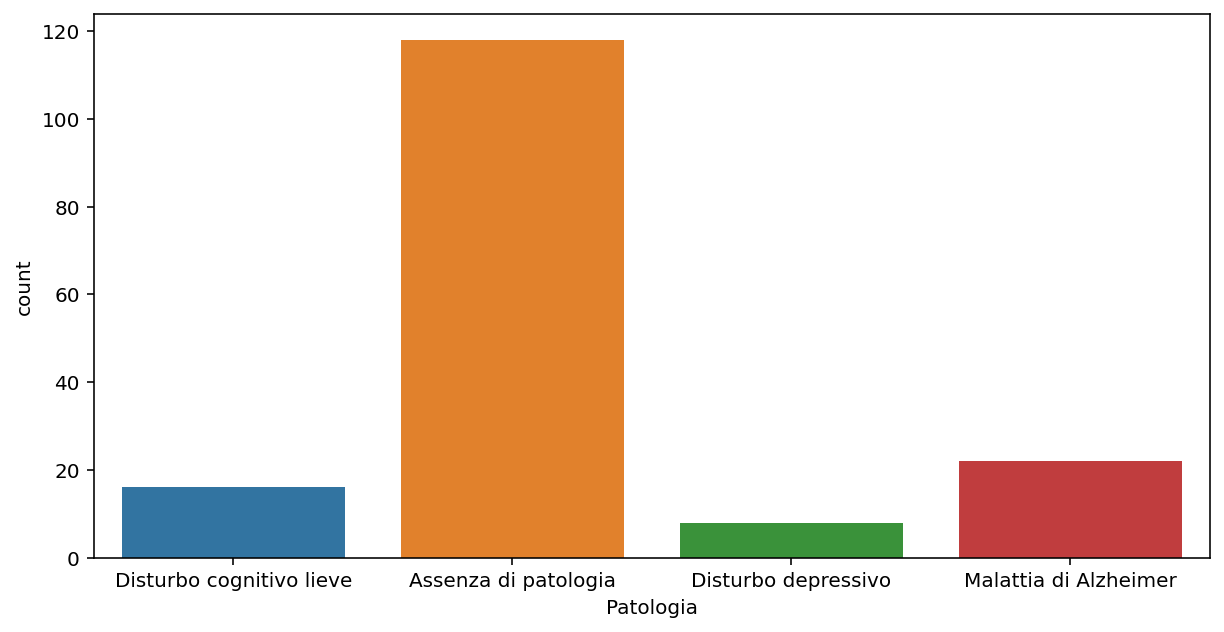

In [136]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df_test.Patologia, ax=ax)
plt.show()

In [137]:
df_test[['ID', 'Patologia']].to_csv('submission/sub_svm.csv', index=False)

In the private leaderboard of Kaggle's competition we can see that model's accuracy is 0.74482, which means that in the previous section we found an accurate estimation.  